# 1. Library Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

# 2. Data Import

In [2]:
data = pd.read_csv("en.openfoodfacts.org.products.csv", sep = '\t', dtype={'code': 'object'})

C:\Users\melme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,13,27,28,29,31,47,52,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option('display.max_columns', data.shape[1])
pd.set_option('display.max_rows', data.shape[0])

In [4]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,375.0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# 3. Functions

- Creation of functions that can be used several times thereafter.

In [5]:
def DataSetsExplo(df):
    print("Dataset has ", df.shape[0], "rows and ", df.shape[1], "columns")
    
    print("Number of non-null values by columns :")
    print(df.count())
    
    plt.figure(figsize = (45,15))
    plt.title('Number of non-null values by columns', fontsize = 30)
    plt.xlabel('columns', size = 20)
    plt.ylabel('number of non-null values', size = 20)
    plt.xticks(fontsize = 20, rotation = 90)
    plt.yticks(fontsize = 20)
    sns.barplot(x = df.columns, y = df.count())

    print("Value type per column :")
    print(df.dtypes)

In [6]:
def FilteringColumnsNaN(df, threshold):
    df = df[df.columns[df.isna().sum()/df.shape[0] < threshold]]
    return df

In [7]:
def FilteringMaxMinValuesPossible(df, maxval, minval, columns):
    for col in columns:
        index = df[(df[col] > maxval) | (df[col] < minval)].index
        df.drop(index, inplace = True)
    return df

In [8]:
def aberrantvalues(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1-1.5*IQR
        upper = Q3+1.5*IQR
        #df[df[col] < lower] = df[col].quantile(0.5)
        #df[df[col] > upper] = df[col].quantile(0.5)
        df.loc[df[col] < lower, col] = np.nan
        df.loc[df[col] > upper, col] = np.nan
    return df

In [9]:
def aberrantvalues_2(df, columns):
    for col in columns:
        lower = df[col].quantile(0.05)
        upper = df[col].quantile(0.95)
        df.loc[df[col] < lower, col] = np.nan
        df.loc[df[col] > upper, col] = np.nan
    return df

In [10]:
def FilteringNaN_SimpleImp(df, columns_imp, strat):
    impute = SimpleImputer(missing_values = np.nan, strategy = strat)
    df[columns_imp] = impute.fit_transform(df[columns_imp])
    return df

In [11]:
def ImputerMeanByGroup(df, columns, group):
    for col in columns:
        df[col] = df[col].fillna(df.groupby(group)[col].transform('mean'))
    return df

# 4. Data Exploration

- The dataset has 1816972 rows and 186 columns.
- There are a lot of empty or almost empty columns.

In [12]:
df1 = data.copy()

In [13]:
sns.set_theme(style = 'darkgrid')

Dataset has  1816972 rows and  186 columns
Number of non-null values by columns :
code                                          1816972
url                                           1816972
creator                                       1816968
created_t                                     1816972
created_datetime                              1816972
last_modified_t                               1816972
last_modified_datetime                        1816972
product_name                                  1738657
abbreviated_product_name                         6241
generic_name                                   117377
quantity                                       464523
packaging                                      289782
packaging_tags                                 289750
packaging_text                                   4662
brands                                         941007
brands_tags                                    940949
categories                                     865781


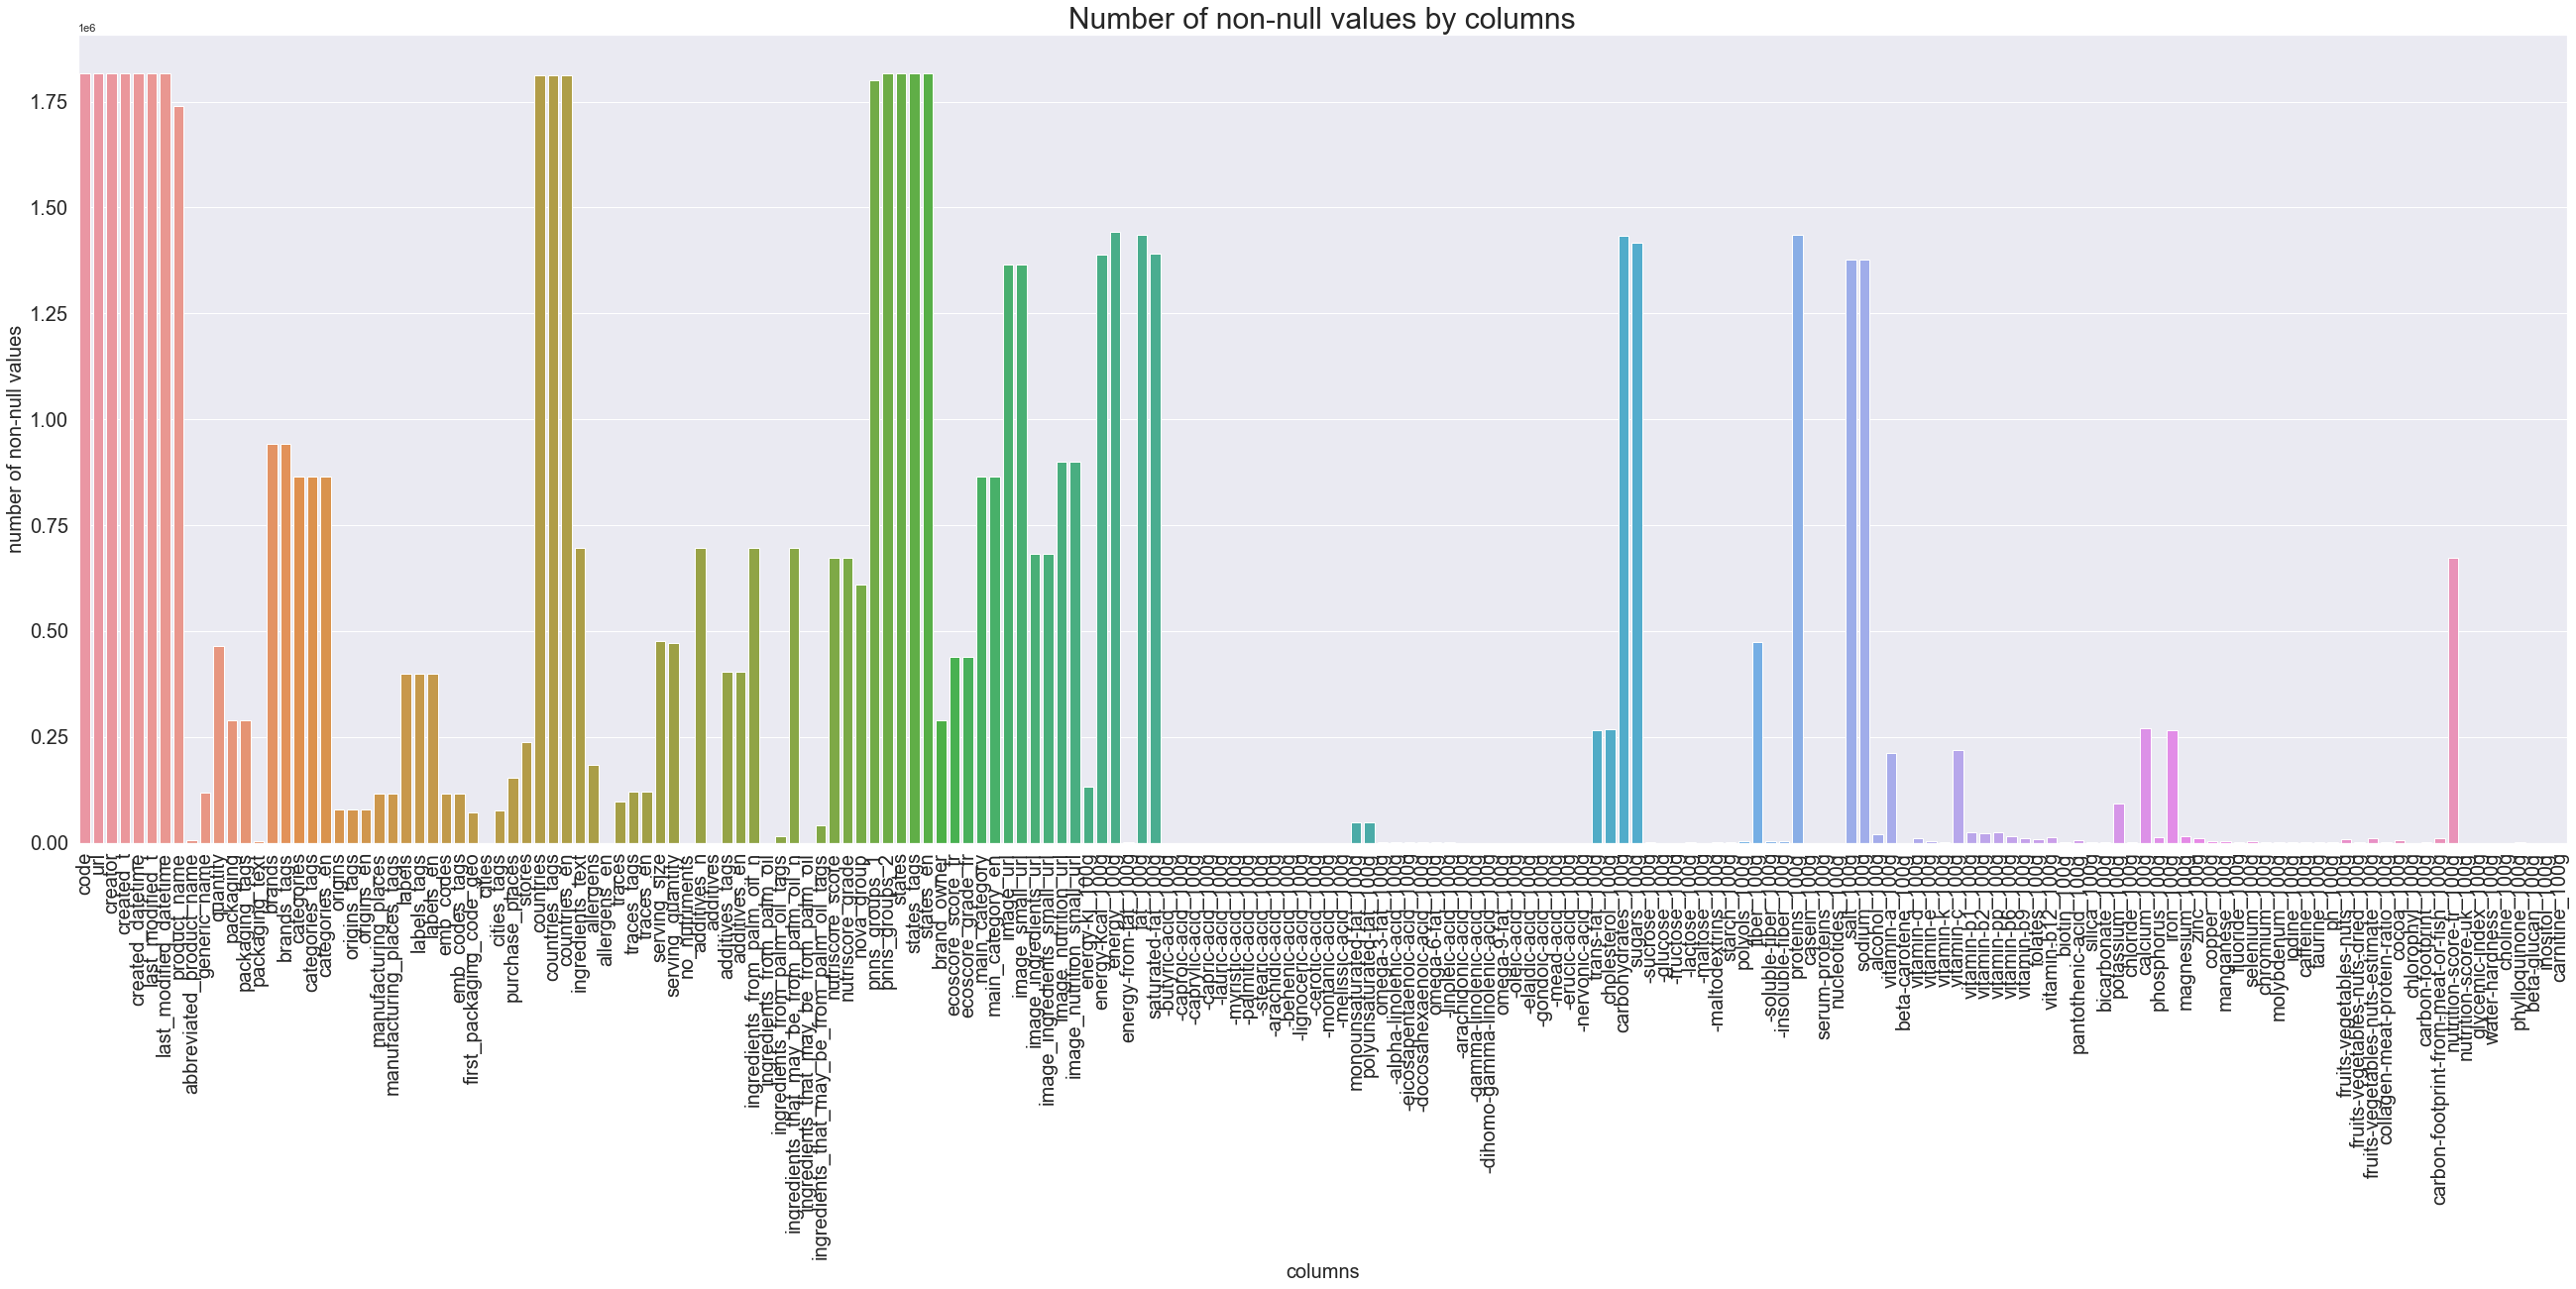

In [14]:
DataSetsExplo(df1)

# 5. Filtering the dataset

- Removal of duplicate "codes".
- Removal of empty "codes".
- Removal of empty "product_name".
- Removal of empty "nutriscore_score".
- Removal of empty columns over 65%.
- Removal of unnecessary columns.
- The dataset has now 670271 rows and 20 columns.
- The dataset has fewer missing values.

In [15]:
df1.drop_duplicates(subset = ['code'], keep = 'first', inplace = True)

In [16]:
df1.dropna(subset = ['code'], inplace = True)

In [17]:
df1.dropna(subset = ['product_name'], inplace = True)

In [18]:
df1.dropna(subset = ['nutriscore_score'], inplace = True)

In [19]:
df1 = FilteringColumnsNaN(df1, 0.65)

Dataset has  670271 rows and  55 columns
Number of non-null values by columns :
code                                       670271
url                                        670271
creator                                    670270
created_t                                  670271
created_datetime                           670271
last_modified_t                            670271
last_modified_datetime                     670271
product_name                               670271
quantity                                   256437
brands                                     480573
brands_tags                                480556
categories                                 670269
categories_tags                            670269
categories_en                              670269
countries                                  669413
countries_tags                             669412
countries_en                               669412
ingredients_text                           479050
serving_size        

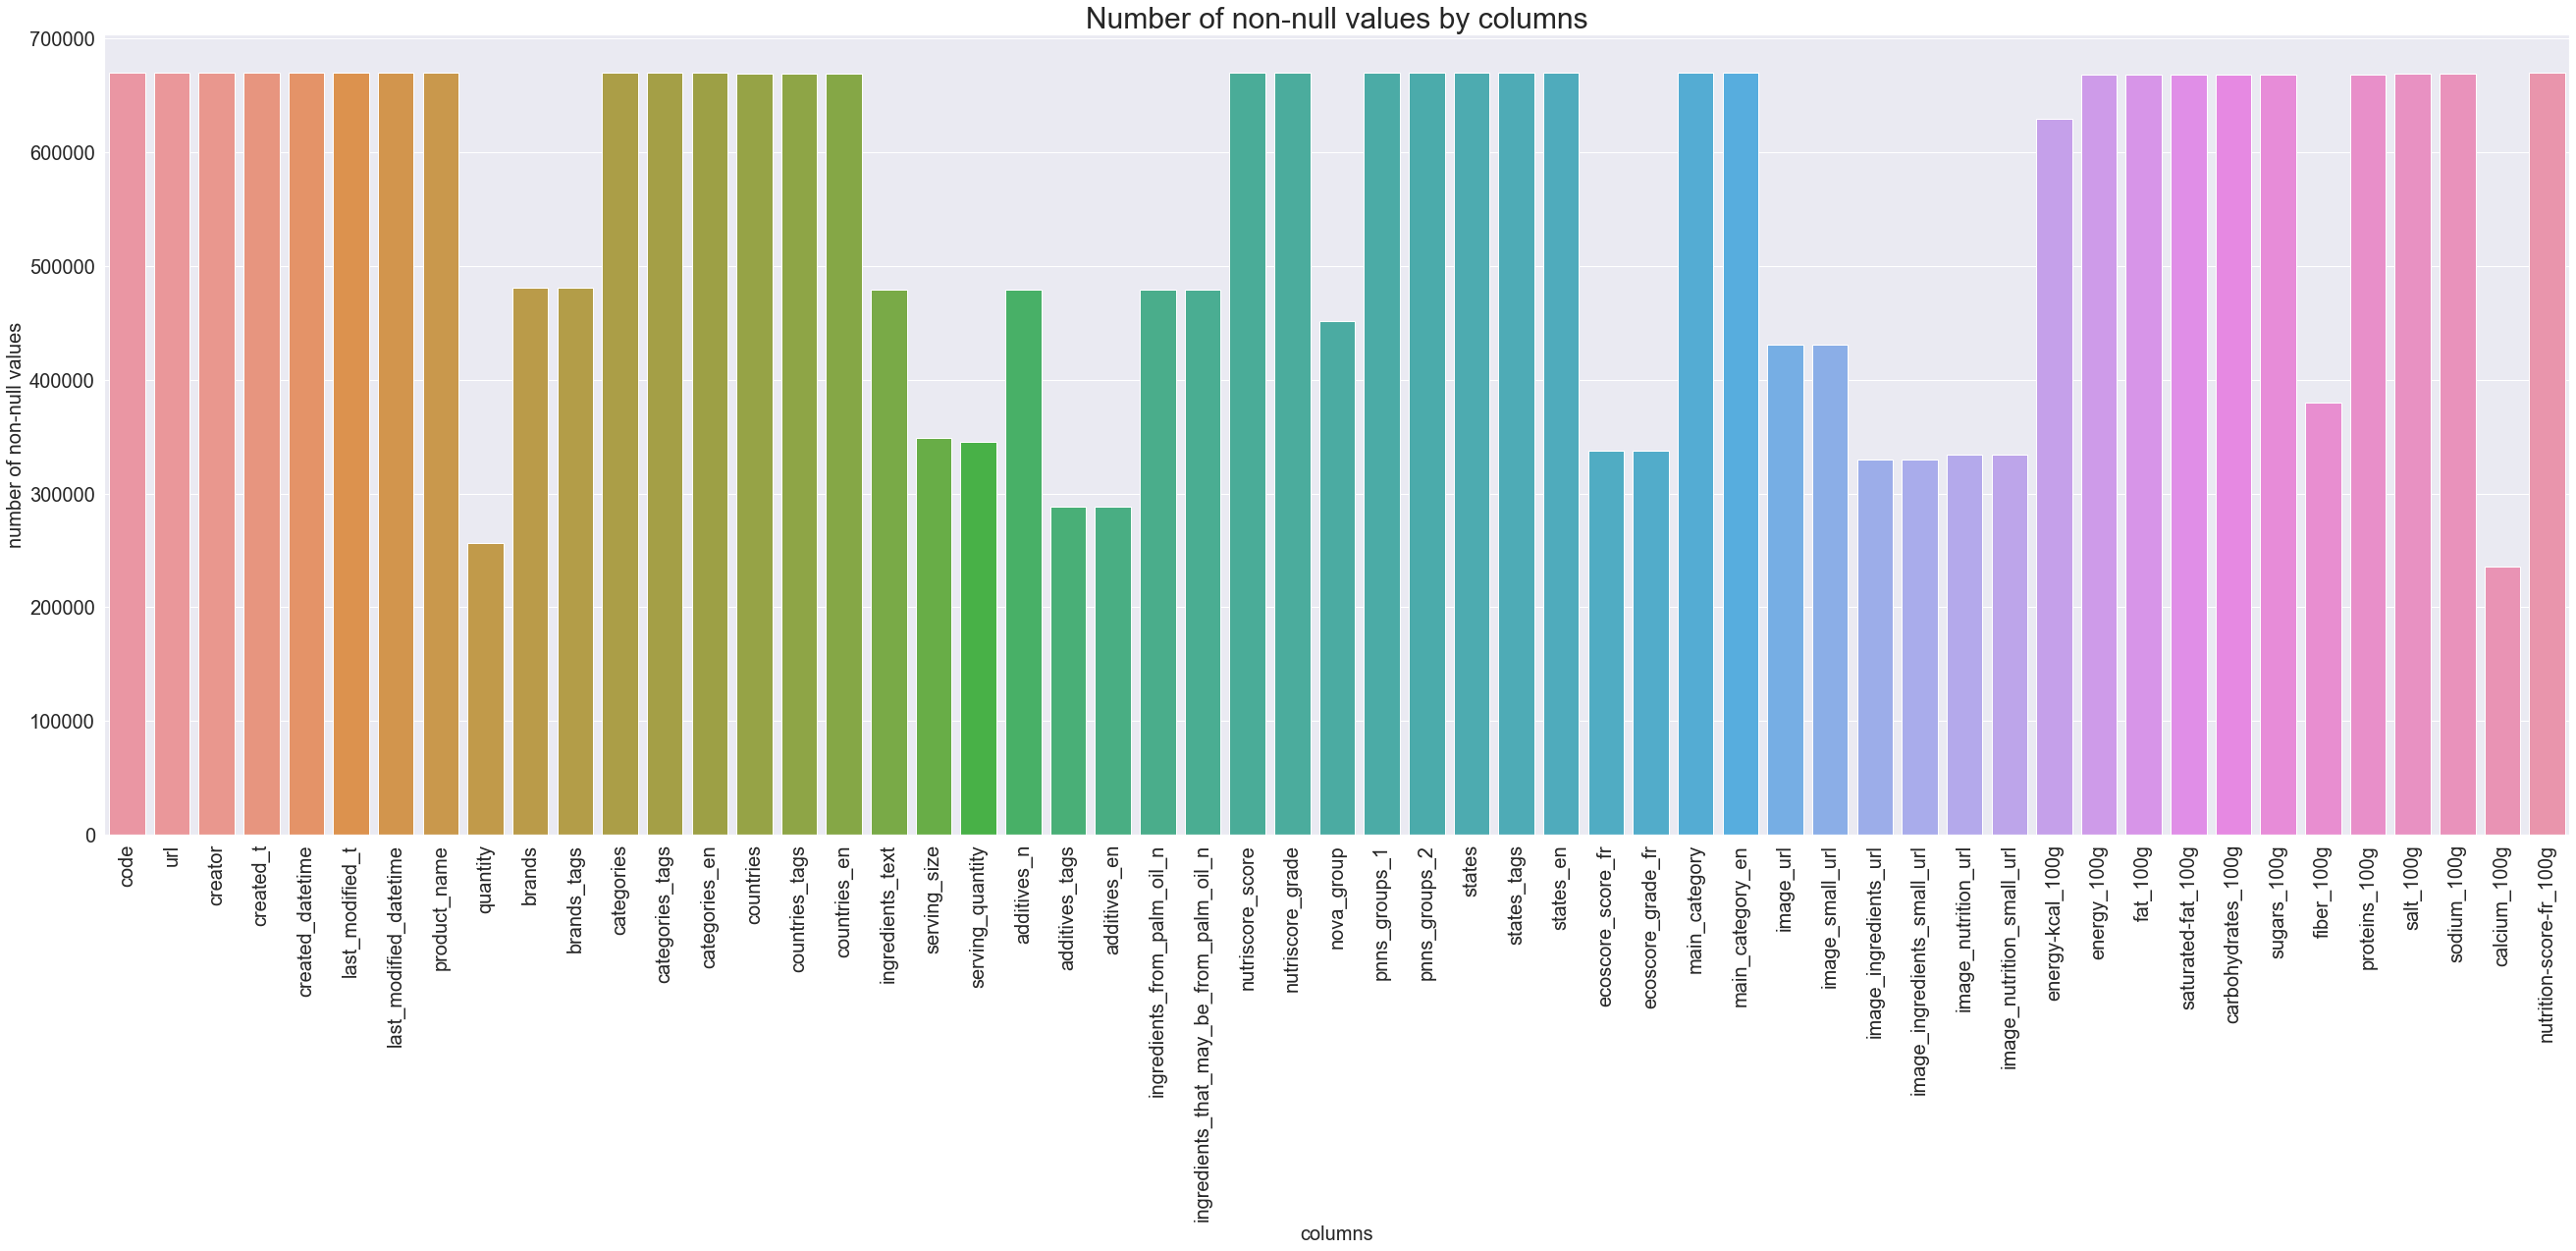

In [20]:
DataSetsExplo(df1)

In [21]:
columns_to_drop = ['url',
                   'creator',
                   'created_t',
                   'created_datetime',
                   'last_modified_t',
                   'last_modified_datetime',
                   'quantity',
                   'brands_tags',
                   'categories_tags', 
                   'categories',
                   'countries_tags',
                   'countries',
                   'serving_size',
                   'serving_quantity',
                   'additives_tags',
                   'additives_en',
                   'ingredients_from_palm_oil_n',
                   'ingredients_that_may_be_from_palm_oil_n',
                   'nova_group',
                   'pnns_groups_1',
                   'pnns_groups_2',
                   'states',
                   'states_tags', 
                   'states_en', 
                   'ecoscore_score_fr',
                   'ecoscore_grade_fr',
                   'main_category',
                   'image_url',
                   'image_small_url',
                   'image_ingredients_url', 
                   'image_ingredients_small_url', 
                   'image_nutrition_url', 
                   'image_nutrition_small_url', 
                   'energy-kcal_100g',
                   'nutrition-score-fr_100g']

In [22]:
df1 = df1.drop(columns = columns_to_drop)

Dataset has  670271 rows and  20 columns
Number of non-null values by columns :
code                  670271
product_name          670271
brands                480573
categories_en         670269
countries_en          669412
ingredients_text      479050
additives_n           479050
nutriscore_score      670271
nutriscore_grade      670271
main_category_en      670269
energy_100g           668608
fat_100g              668564
saturated-fat_100g    668545
carbohydrates_100g    668298
sugars_100g           668553
fiber_100g            380032
proteins_100g         668565
salt_100g             668998
sodium_100g           668998
calcium_100g          236126
dtype: int64
Value type per column :
code                   object
product_name           object
brands                 object
categories_en          object
countries_en           object
ingredients_text       object
additives_n           float64
nutriscore_score      float64
nutriscore_grade       object
main_category_en       object
ene

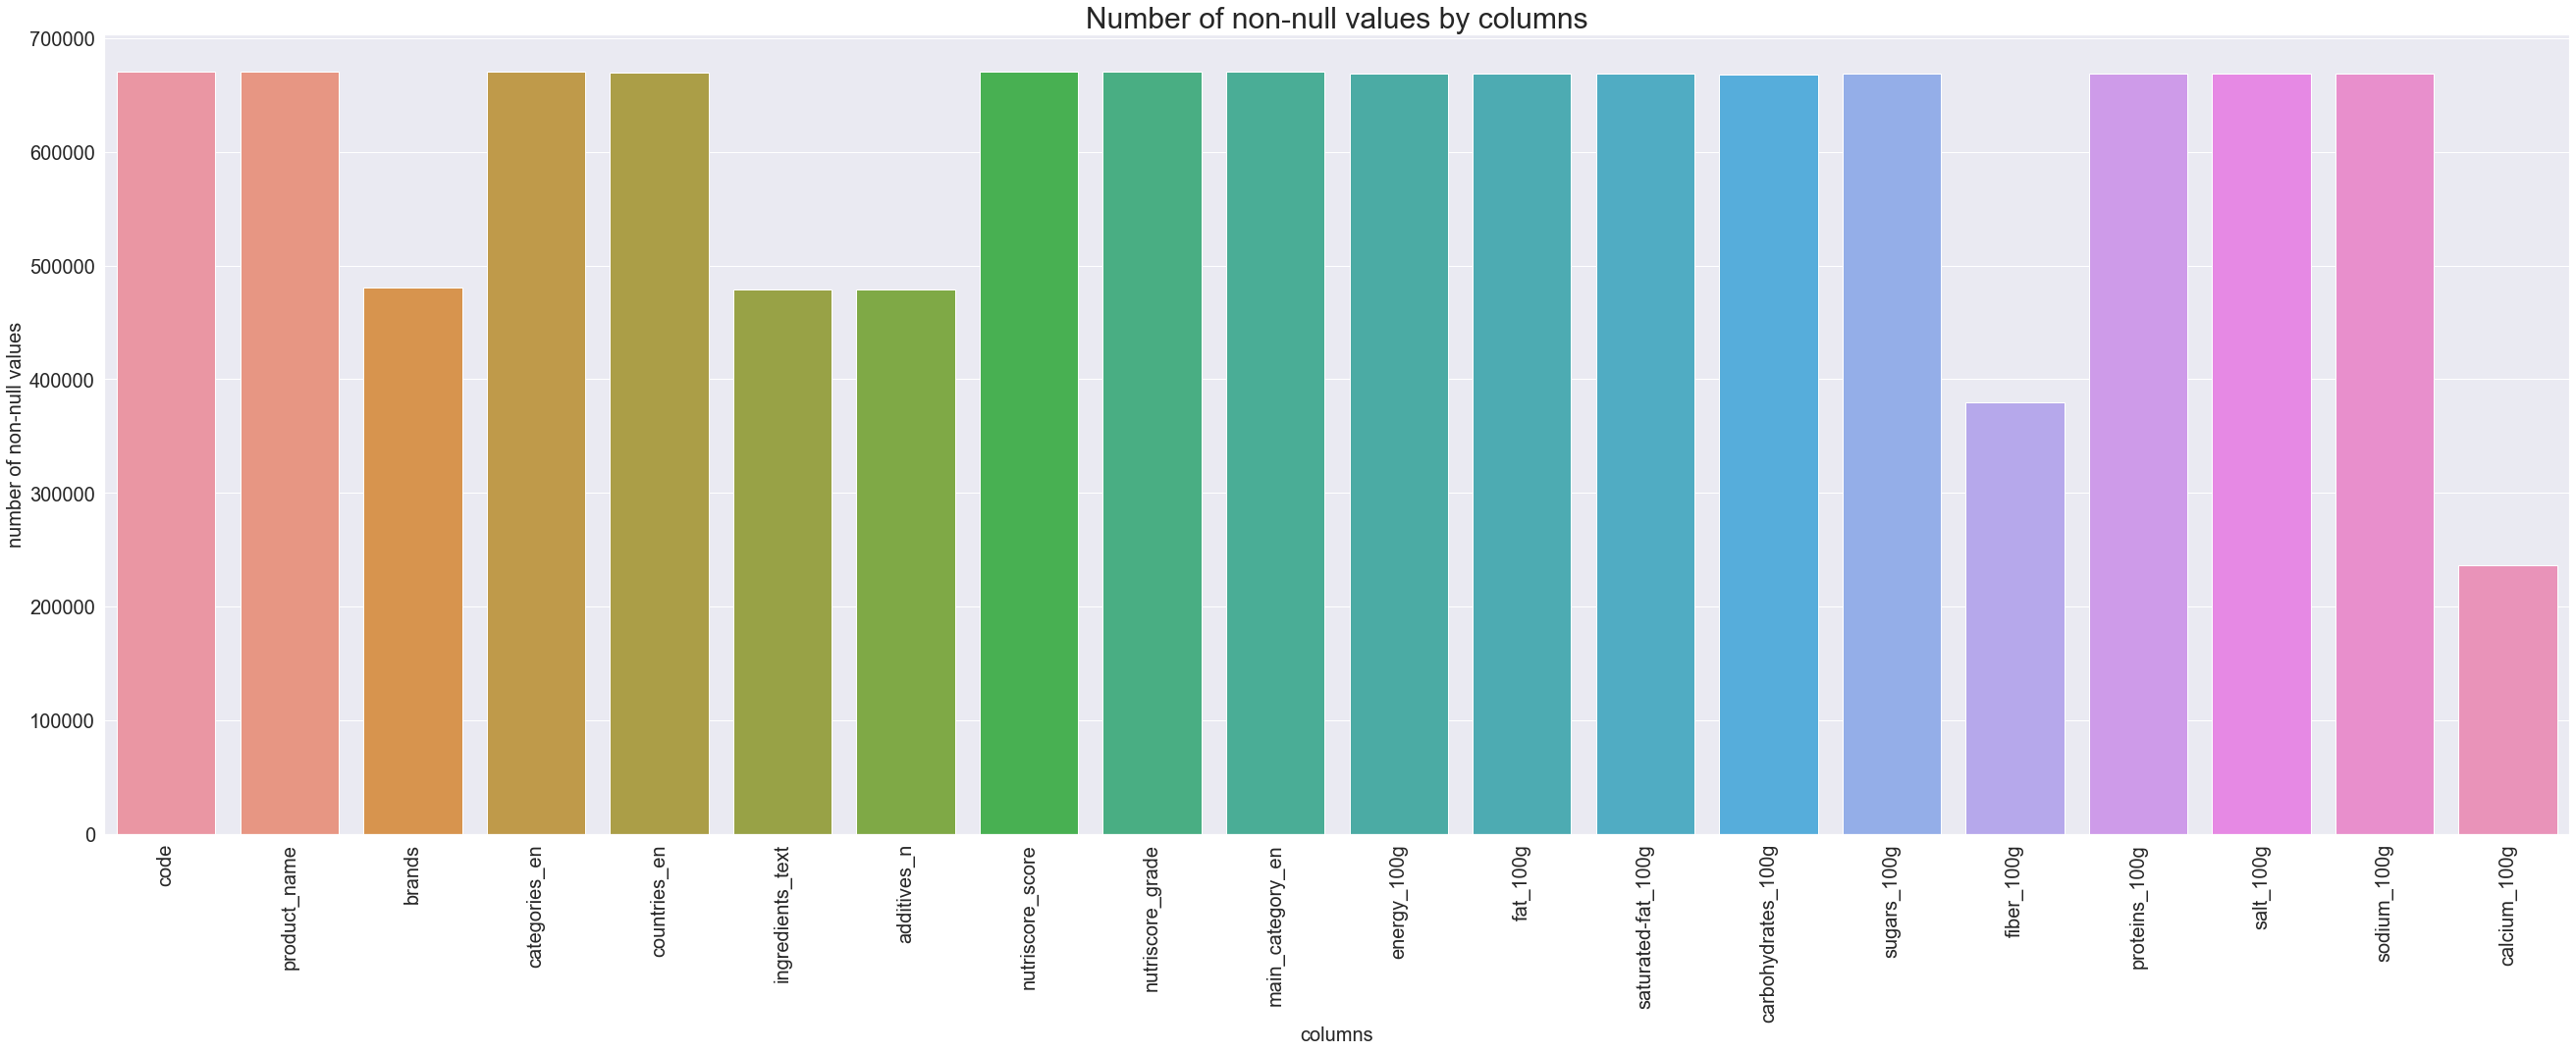

In [23]:
DataSetsExplo(df1)

# 6. Filtering Outliers

- Removal of rows with impossible values (example: fat_100g> 100g or fat_100g <0g).
- Application of the natural log on the float variables to normalize the variables and apply the filtering on the outliers.
- Outliers are replaced by nan to be remplaced by the mean of their main_category_en.
- Return to the original values with the application of the exponential.

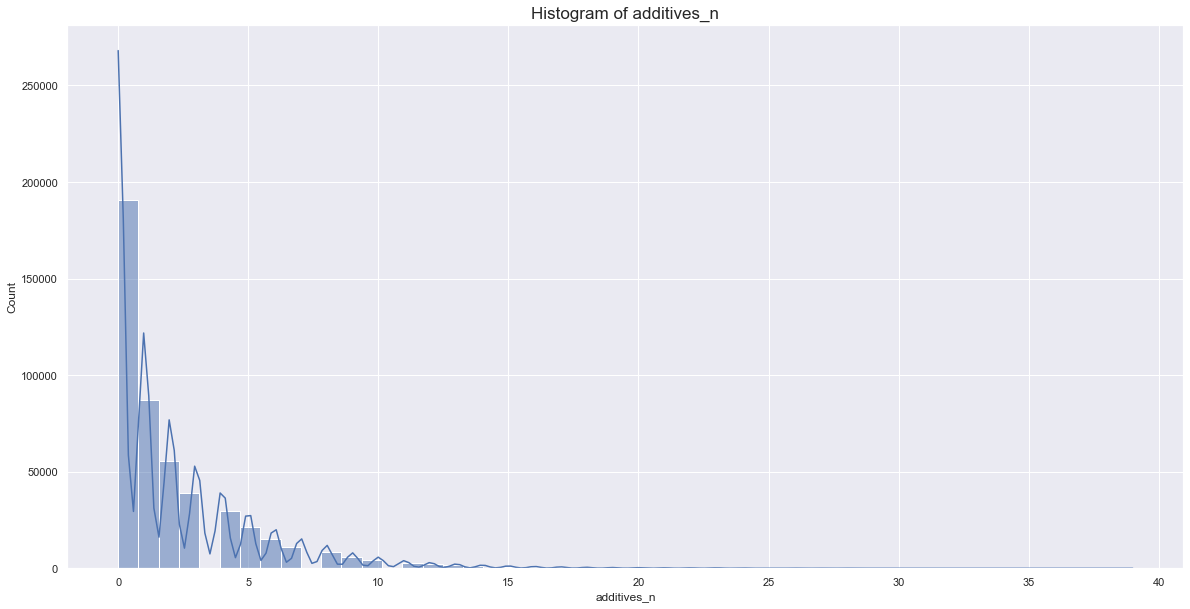

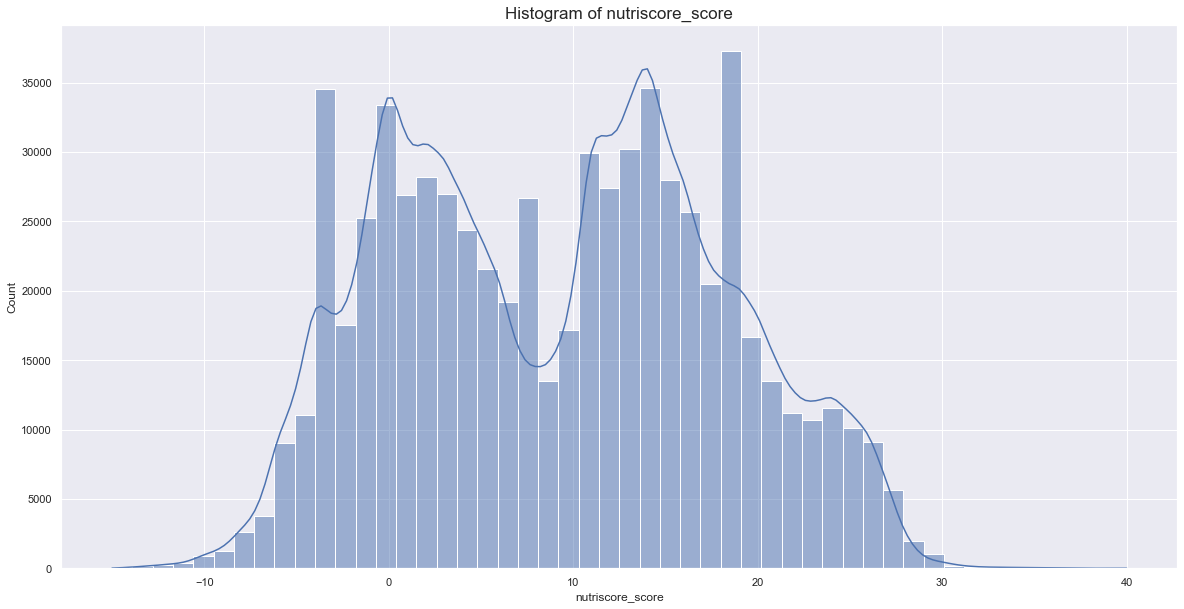

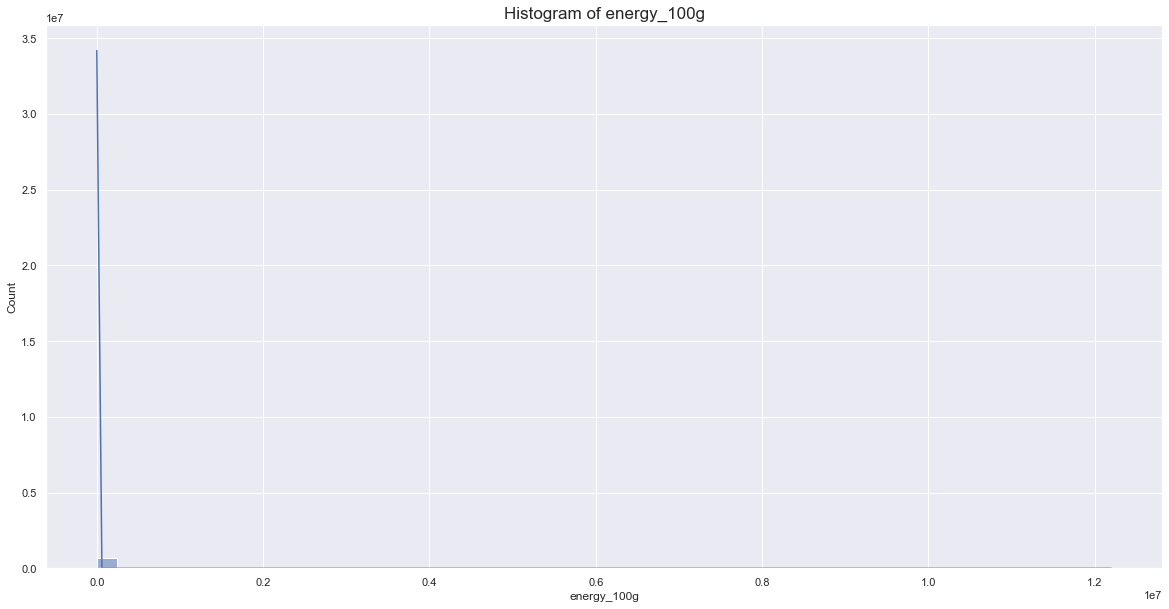

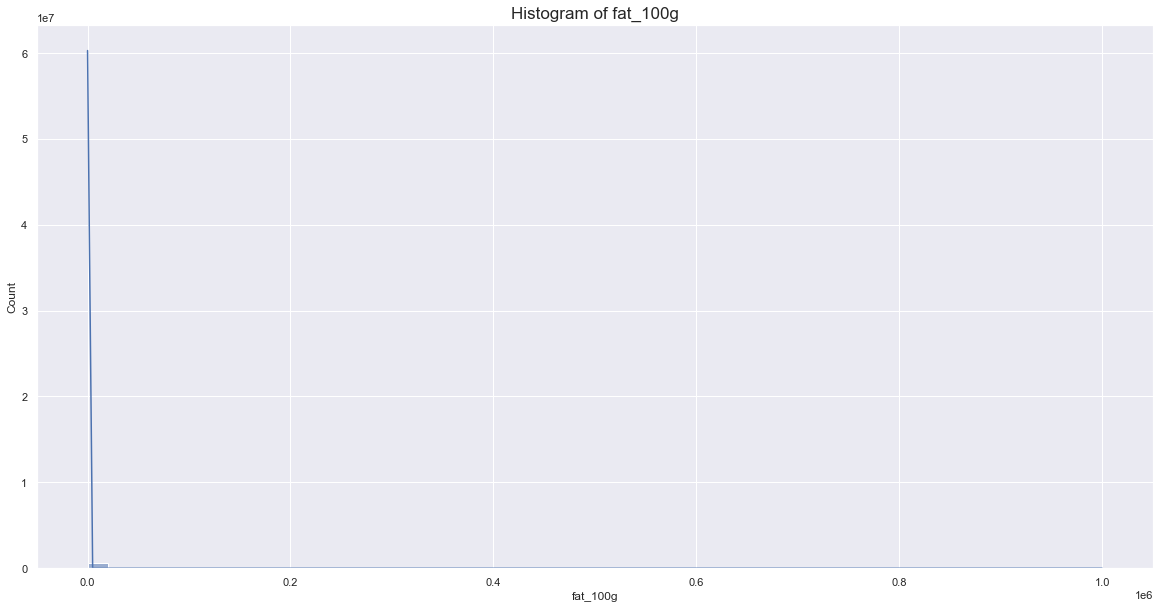

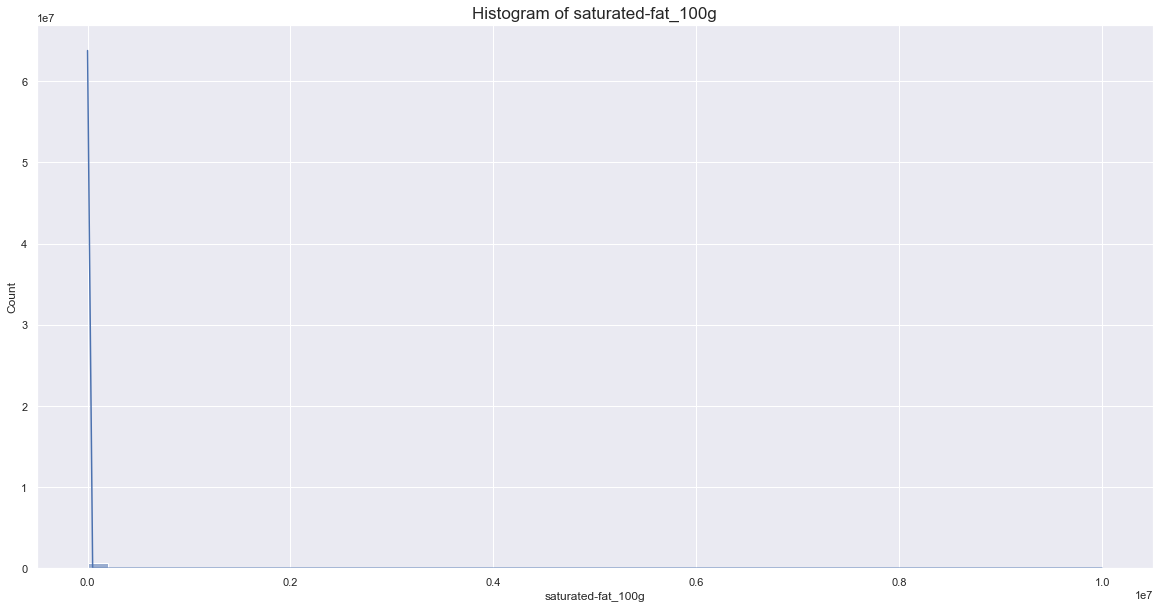

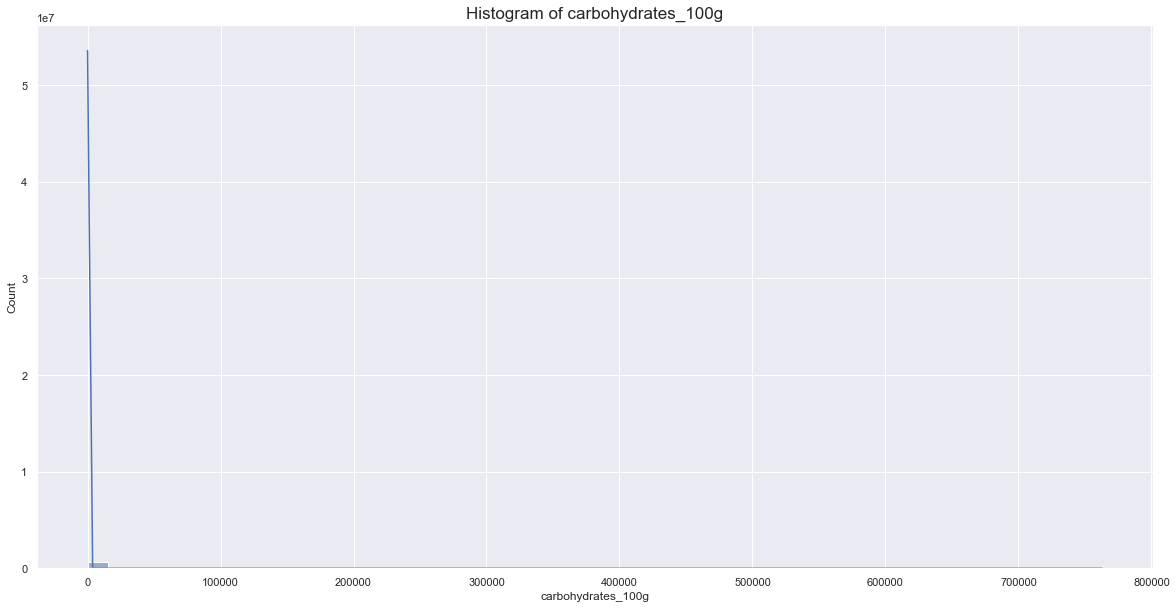

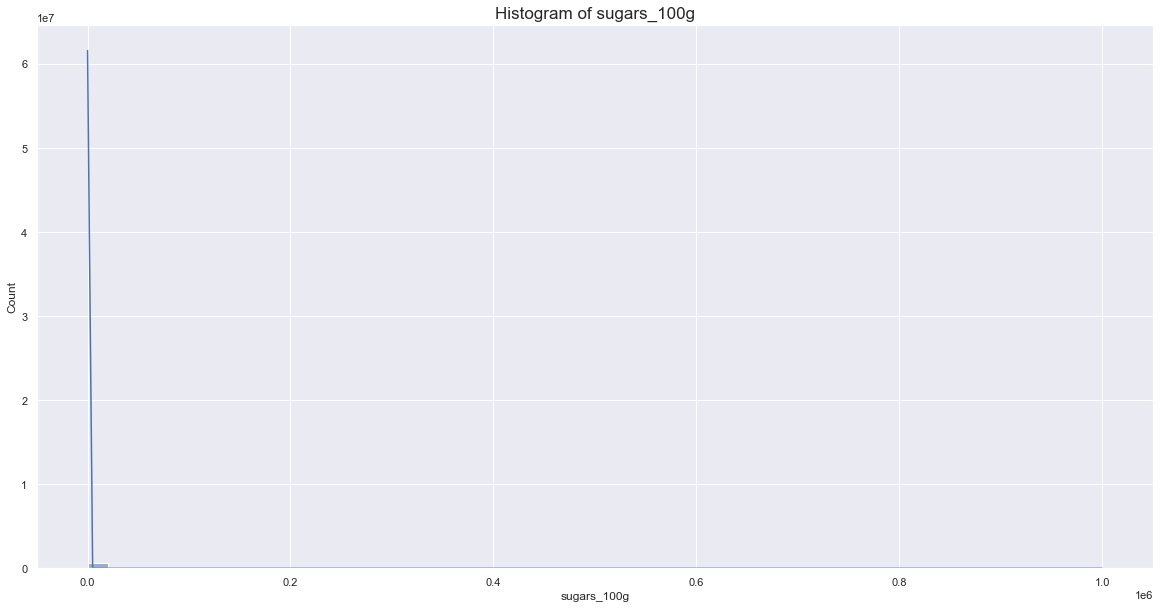

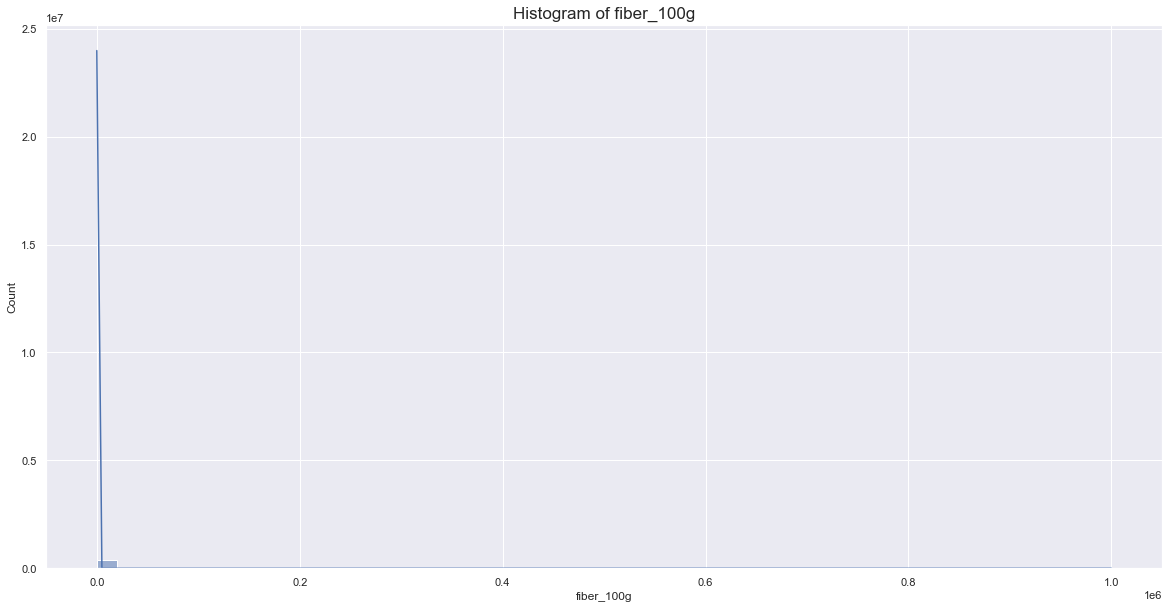

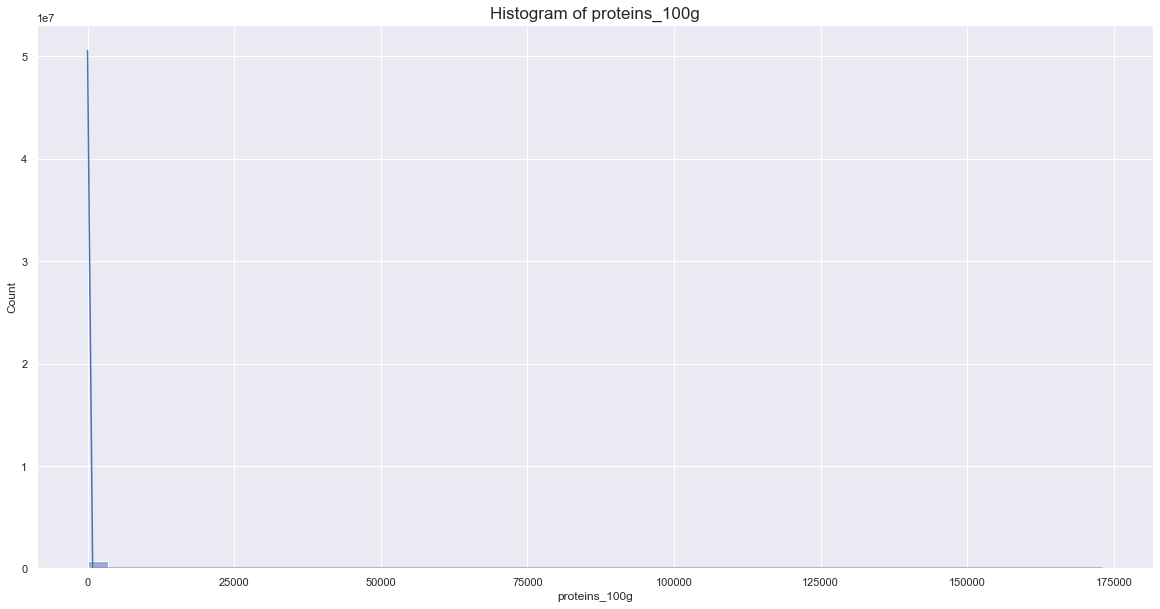

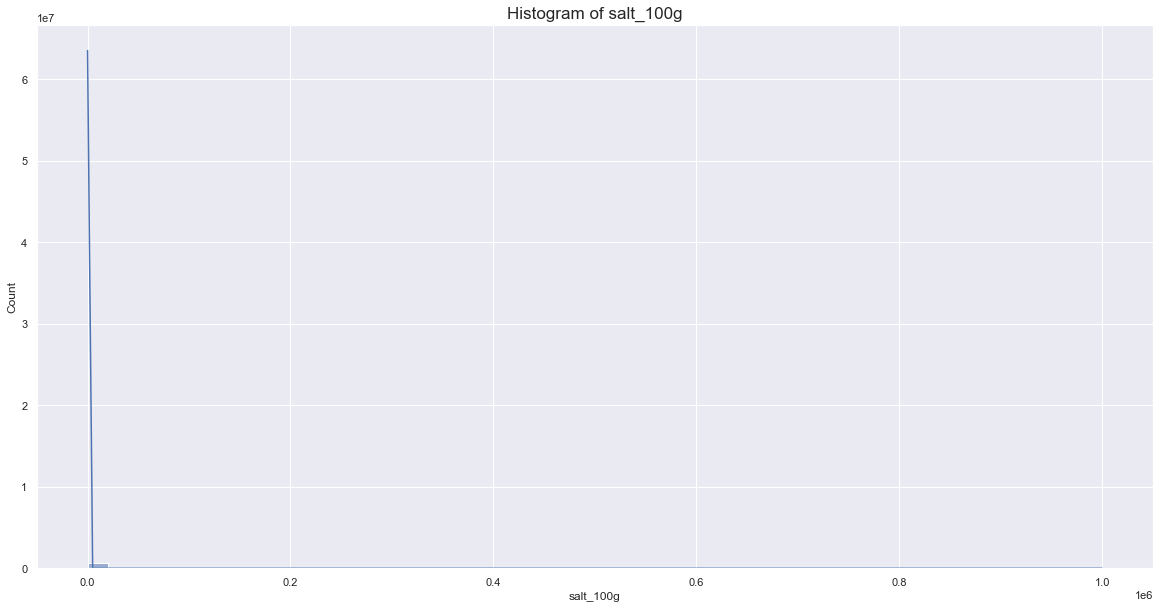

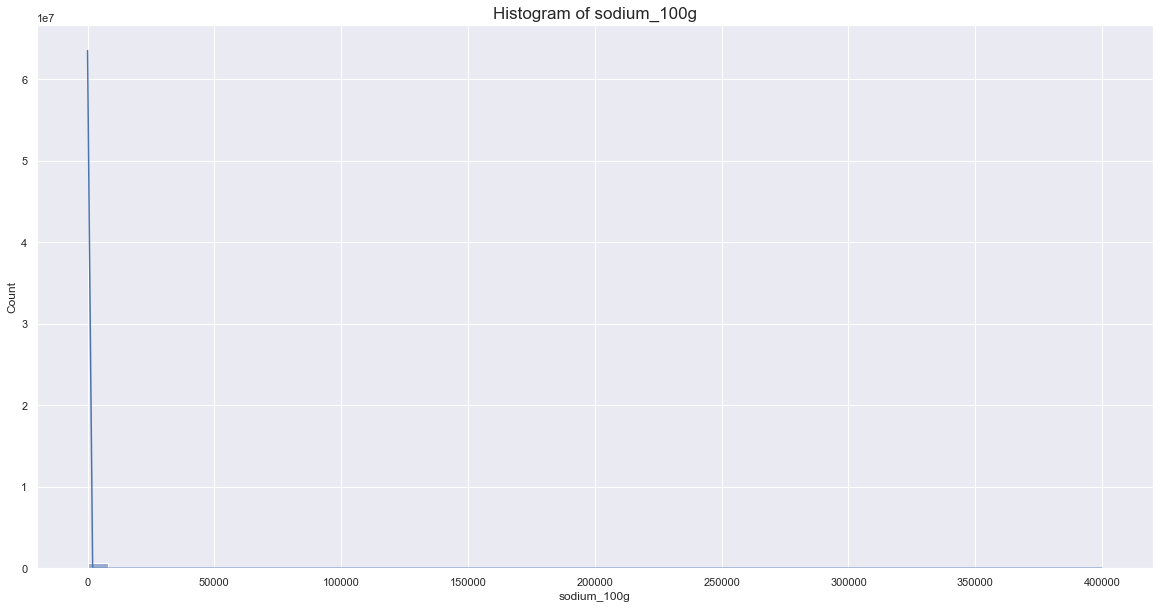

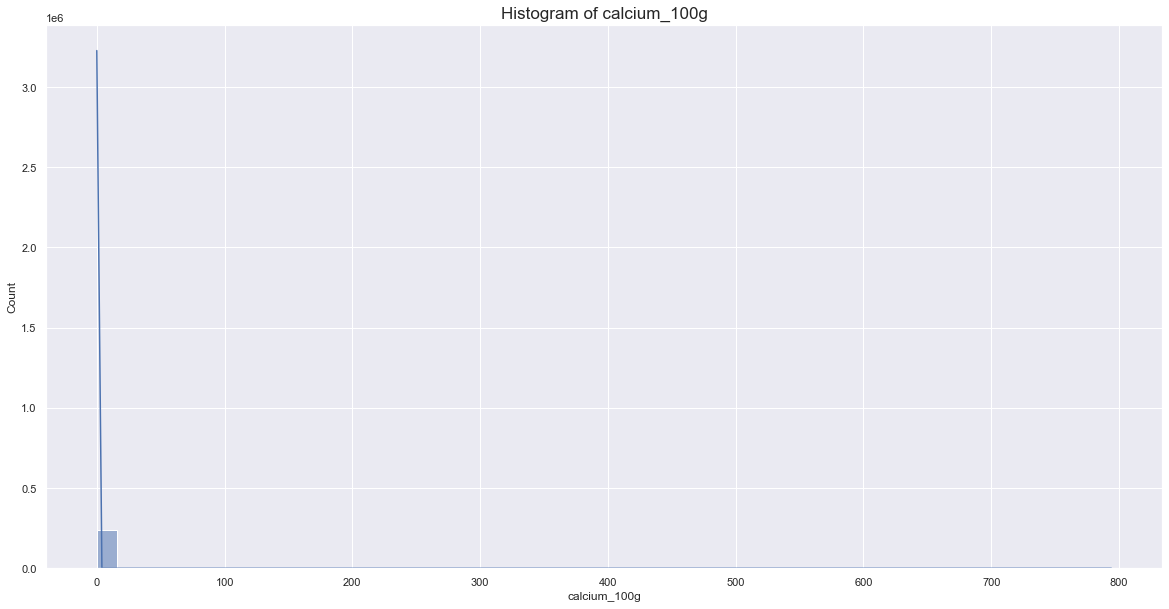

In [24]:
for col in df1.select_dtypes('float'):
    plt.figure(figsize = (20,10))
    plt.title('Histogram of ' + col, size = 17)
    plt.xlabel(col, size = 12)
    sns.histplot(df1[col], bins = 50, kde = True)

In [25]:
columns_to_treat_Min_Max = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'calcium_100g']

In [26]:
df1 = FilteringMaxMinValuesPossible(df1, 100, 0, columns_to_treat_Min_Max)

In [27]:
df1 = FilteringMaxMinValuesPossible(df1, 3700, 0, ['energy_100g'])

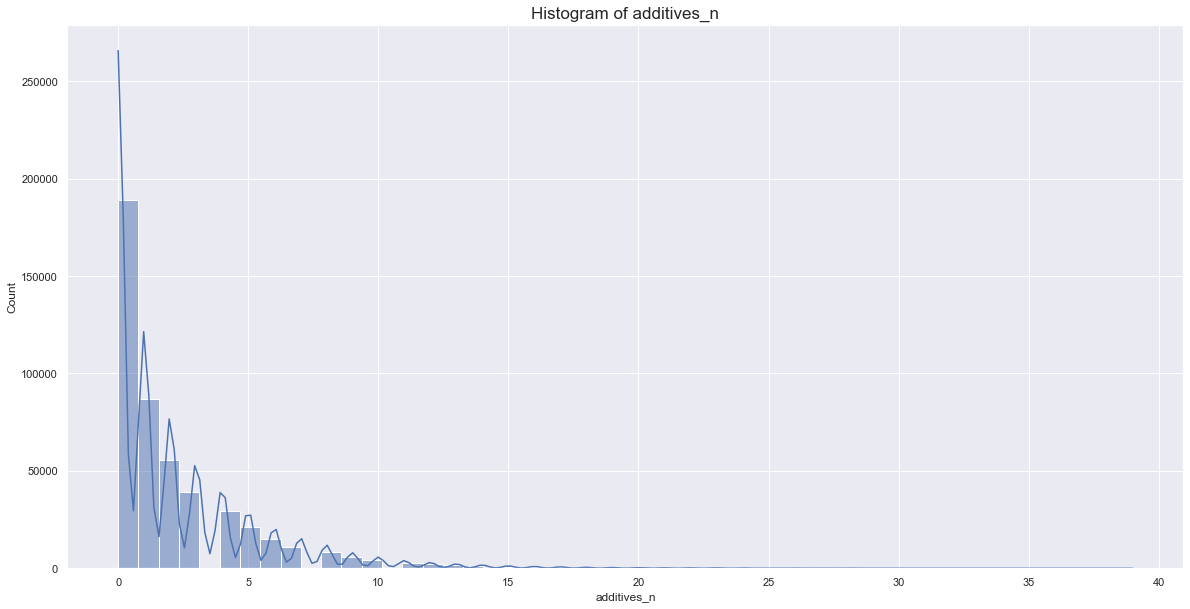

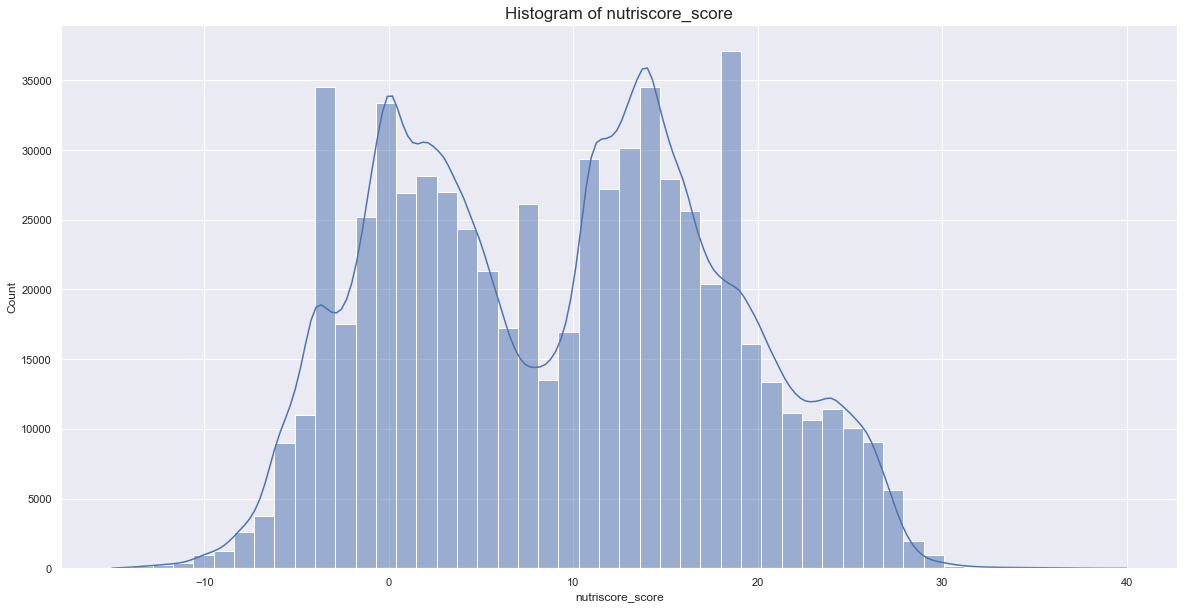

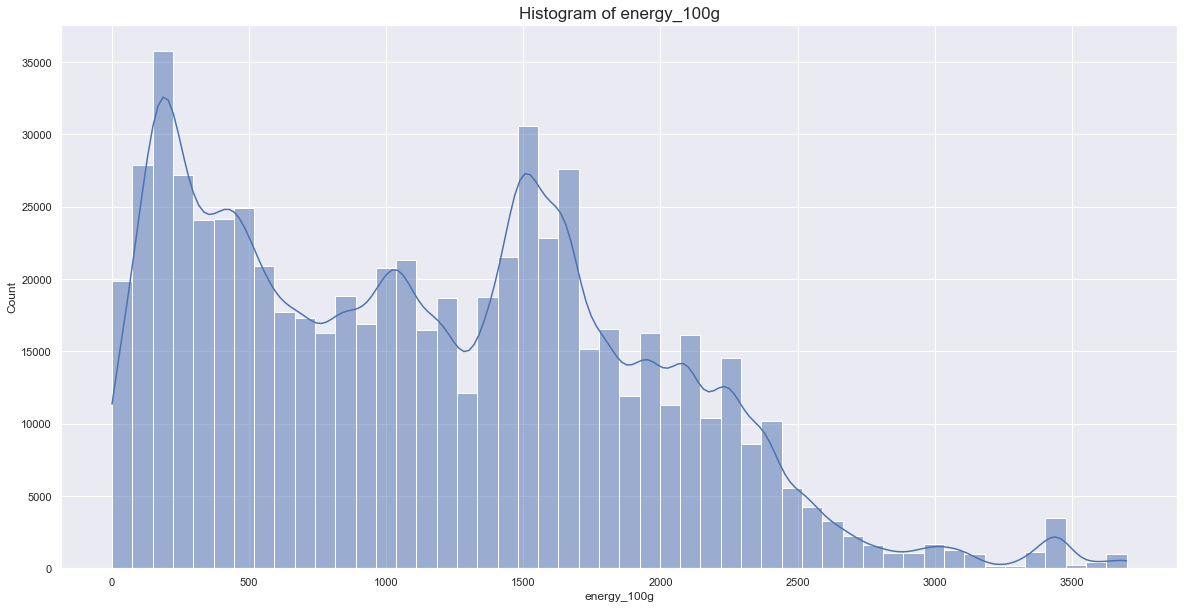

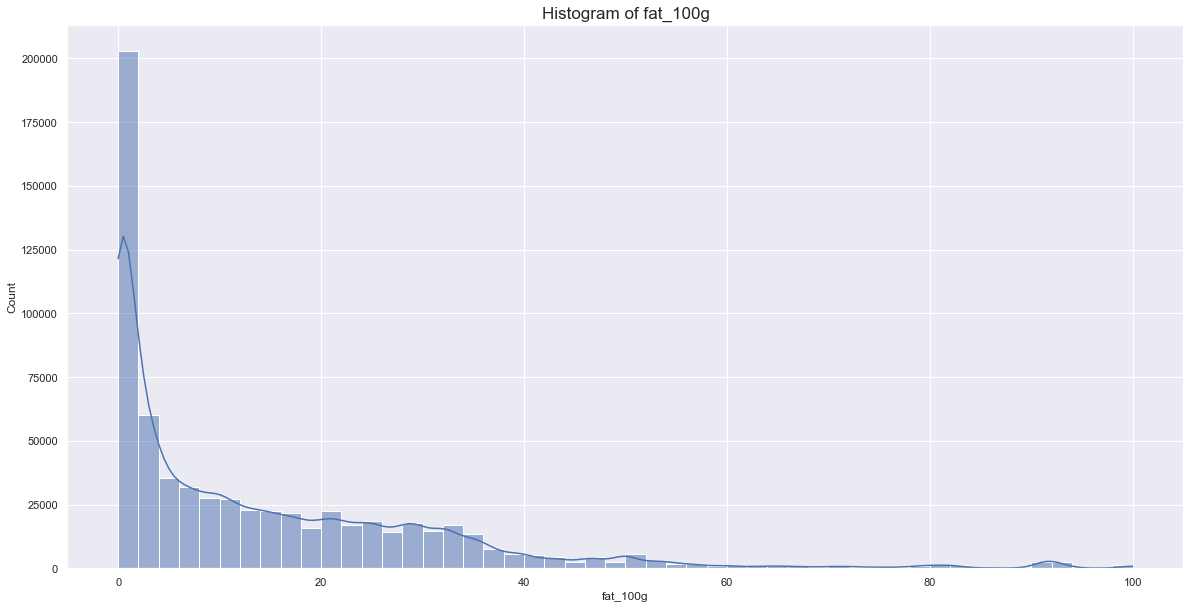

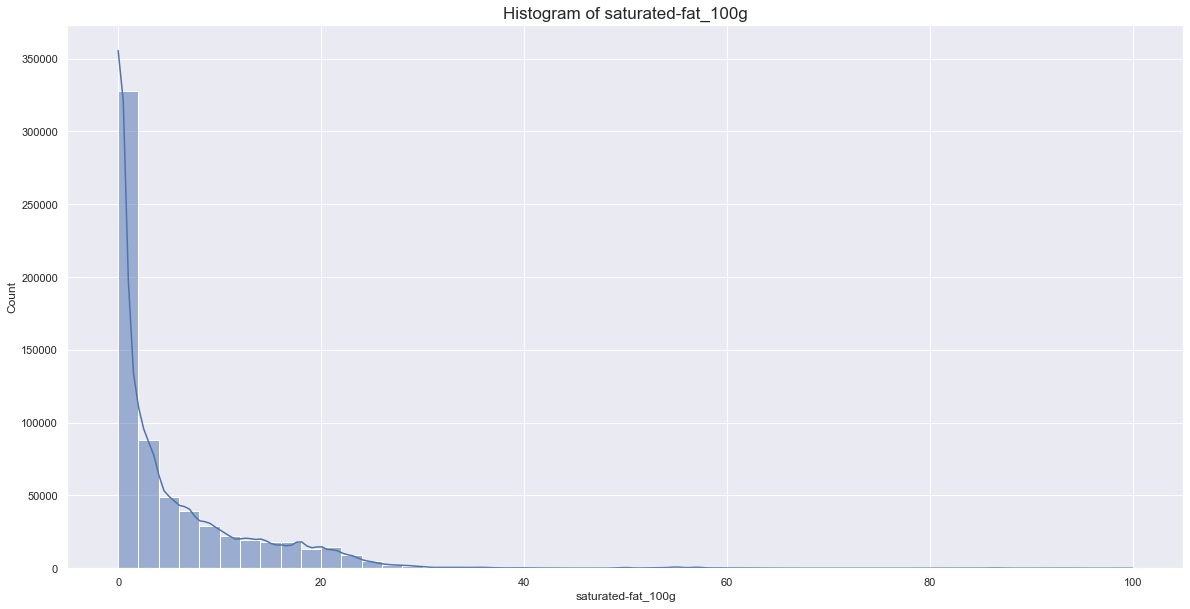

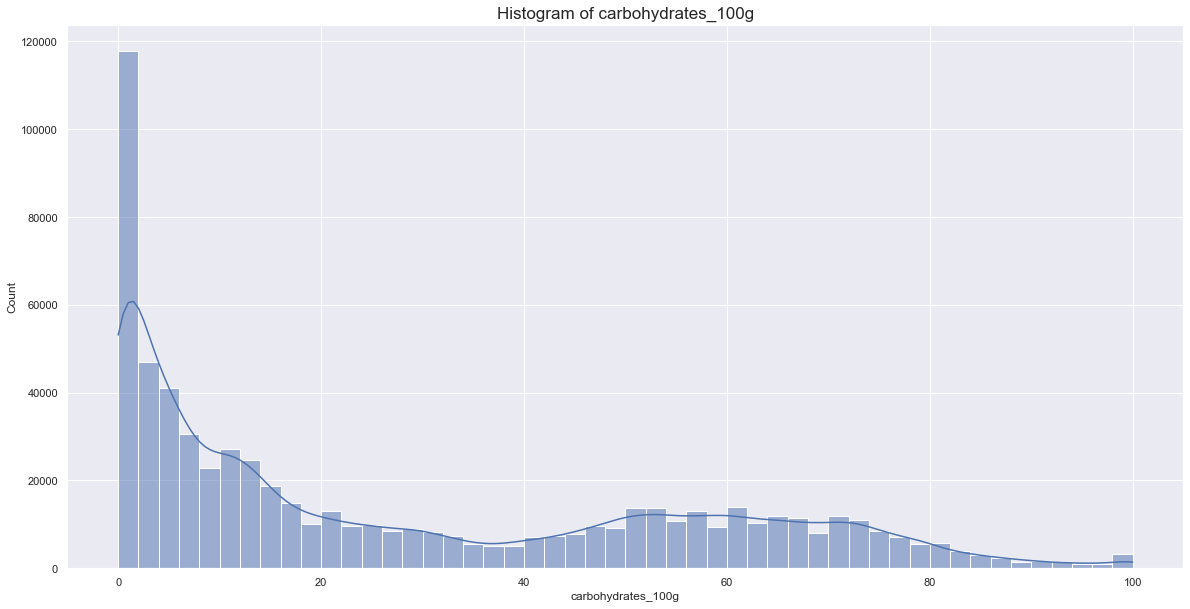

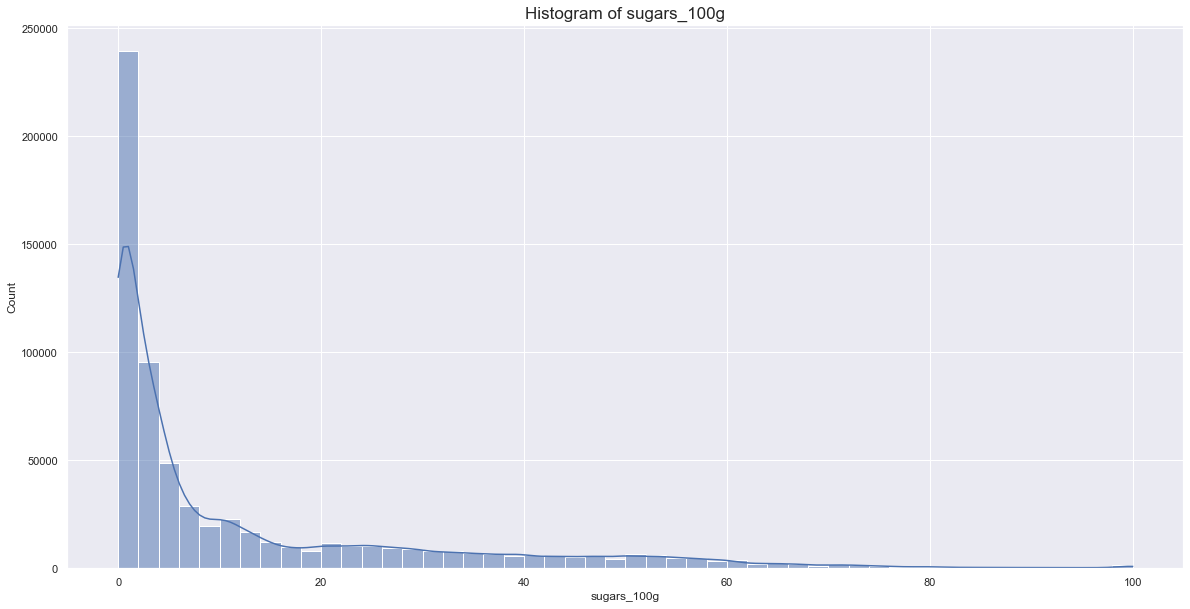

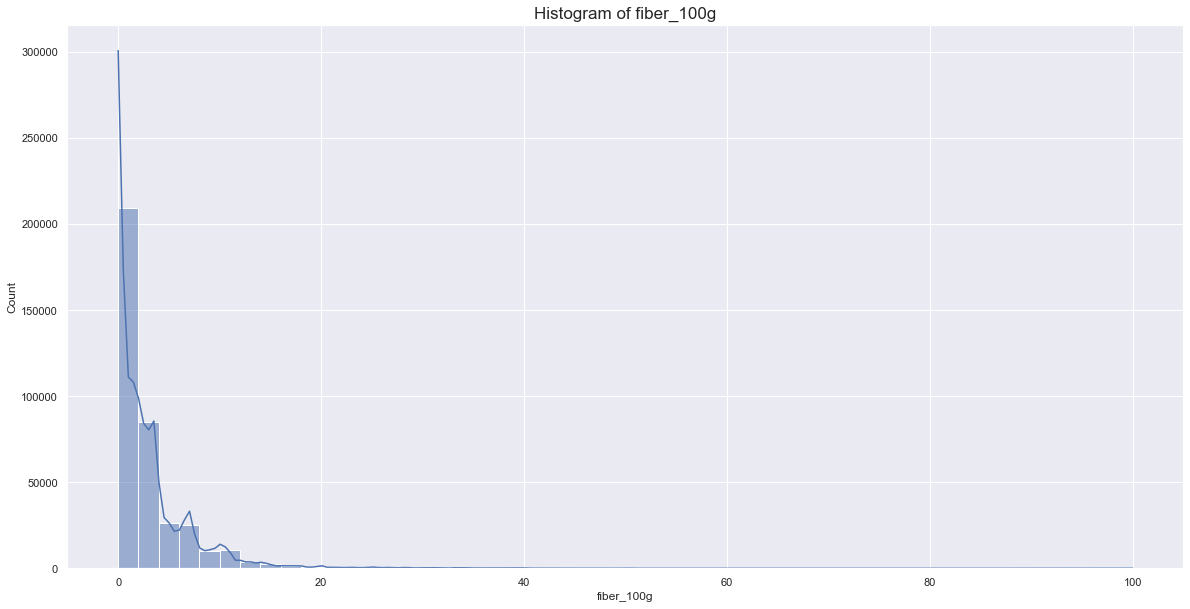

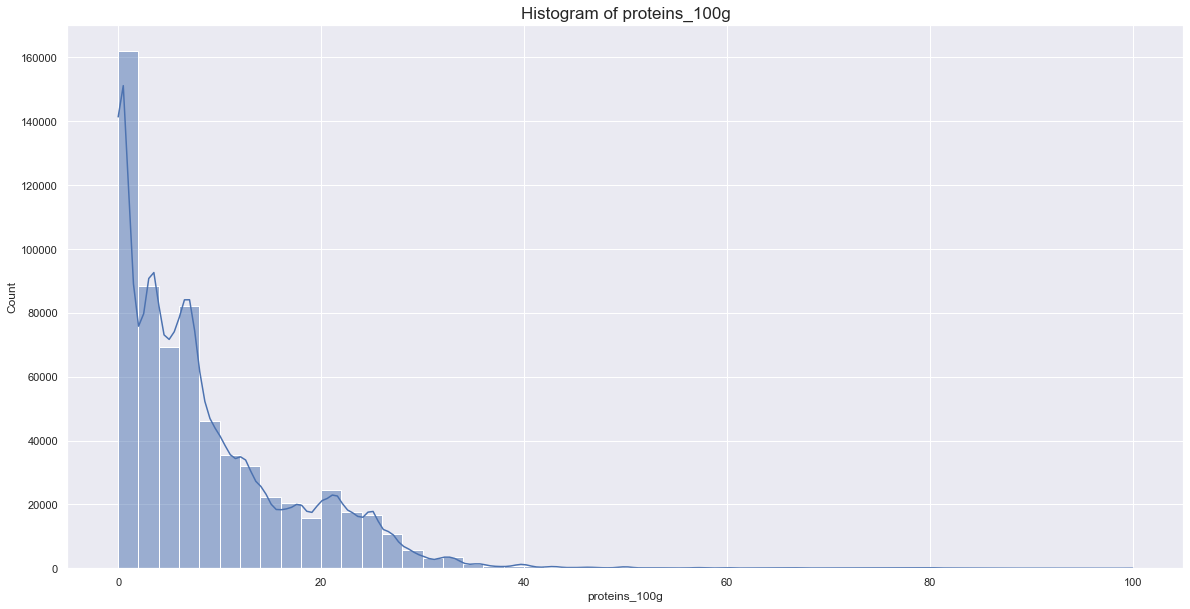

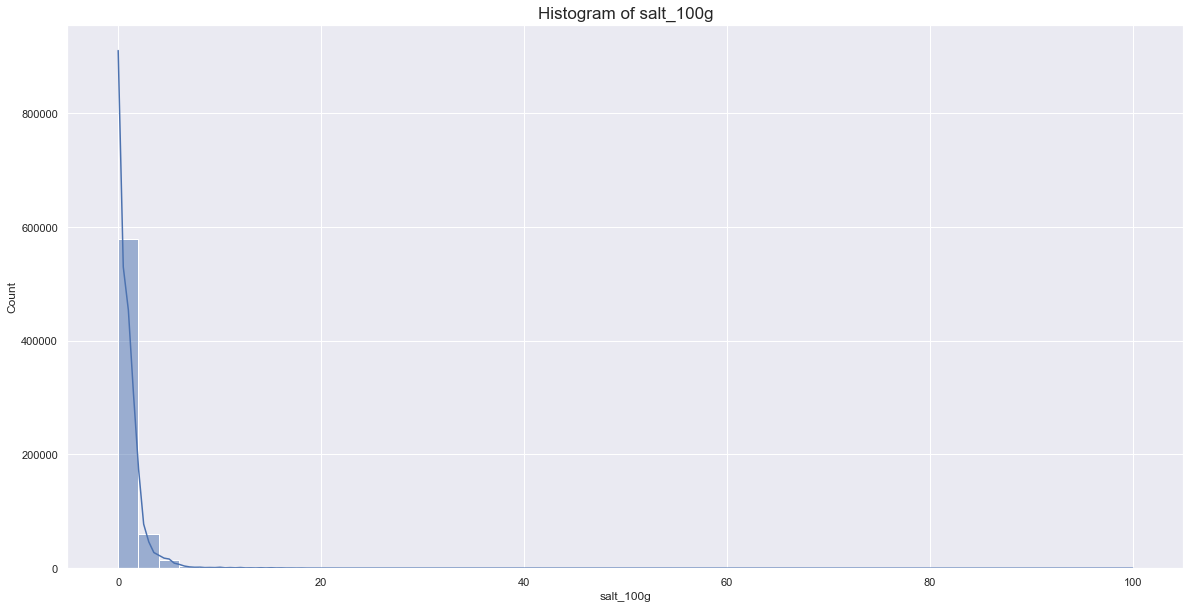

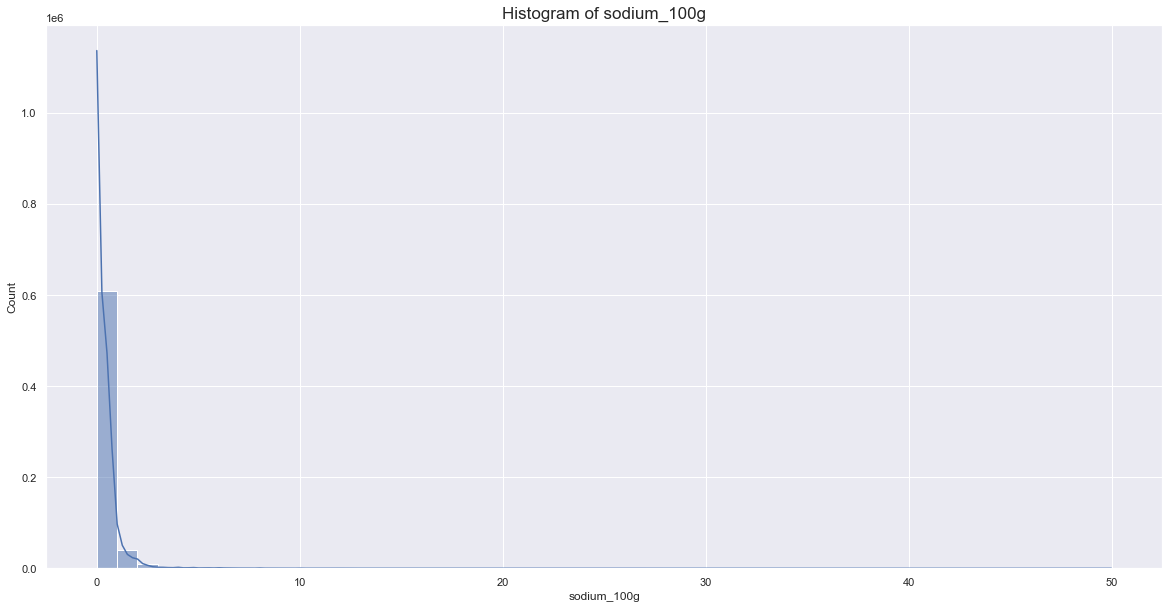

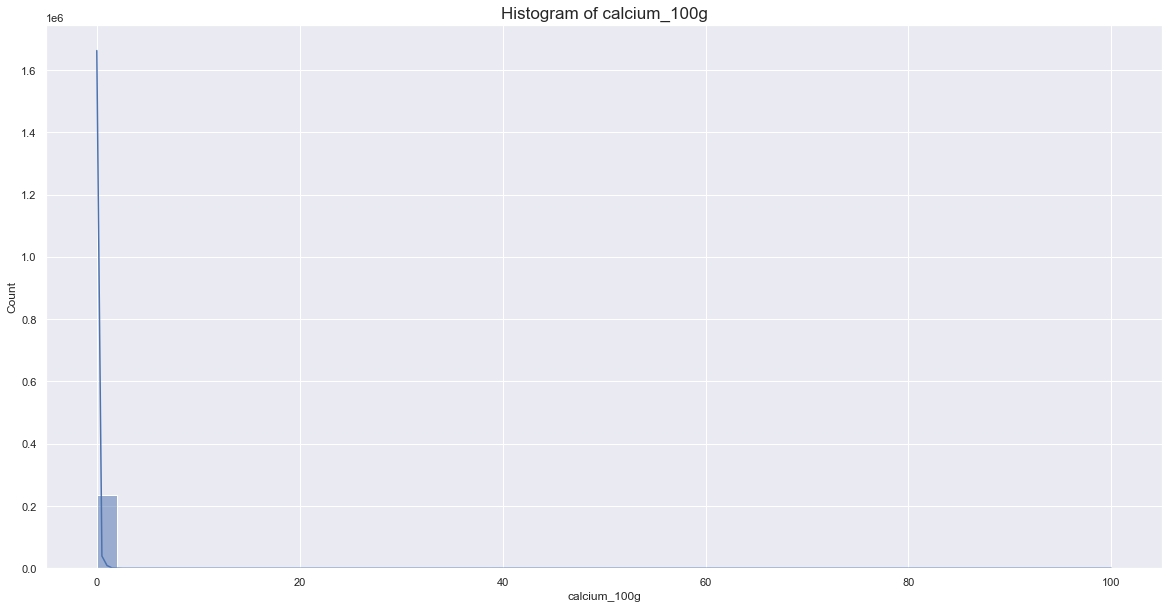

In [28]:
for col in df1.select_dtypes('float'):
    plt.figure(figsize = (20,10))
    plt.title('Histogram of ' + col, size = 17)
    plt.xlabel(col, size = 12)
    sns.histplot(df1[col], bins = 50, kde = True)

In [29]:
columns_to_treat = ['additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'calcium_100g']

In [30]:
df1log = np.log1p(df1[columns_to_treat])

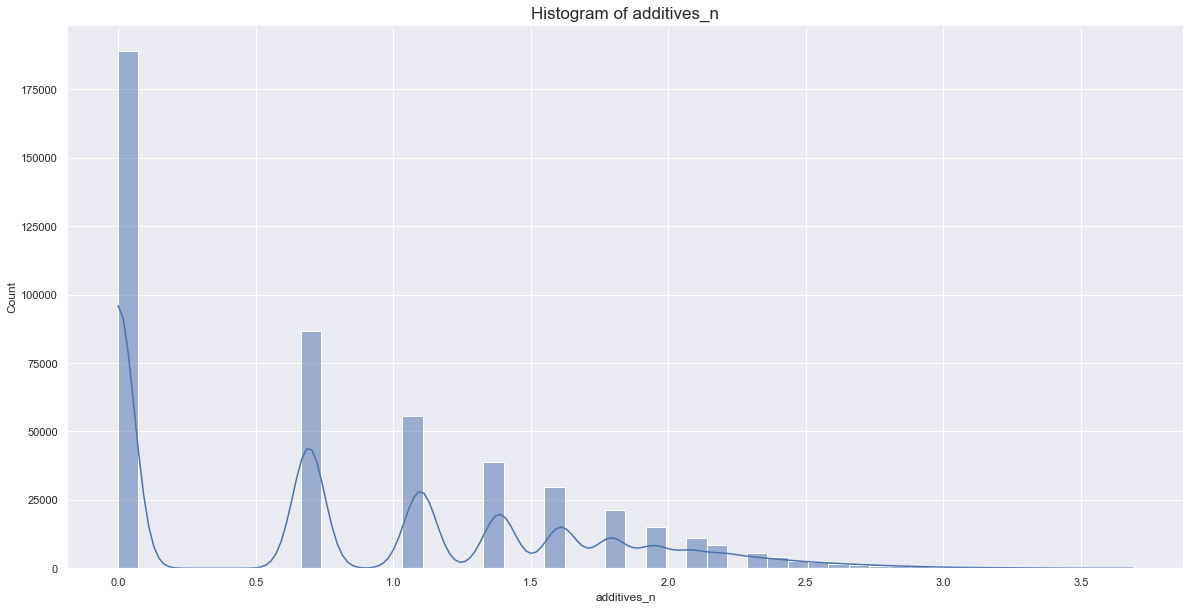

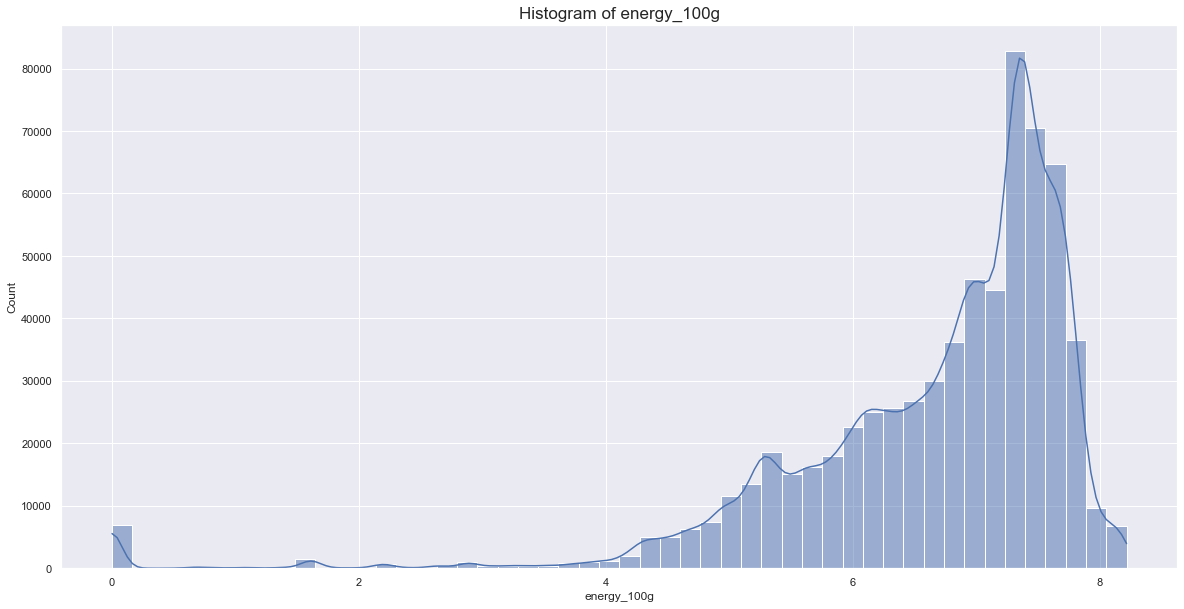

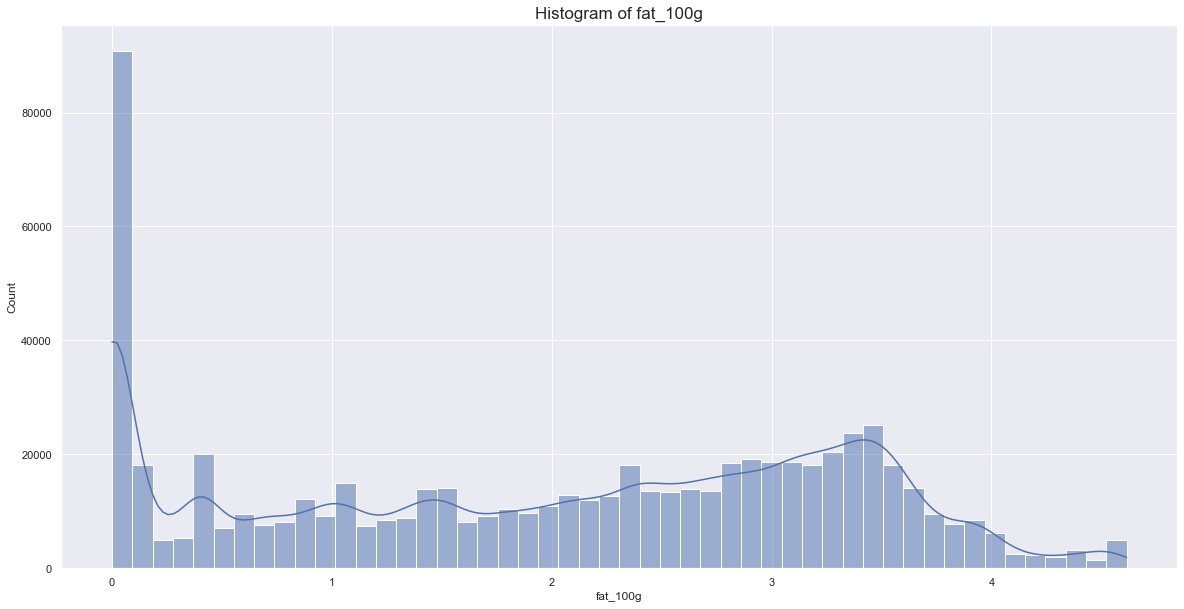

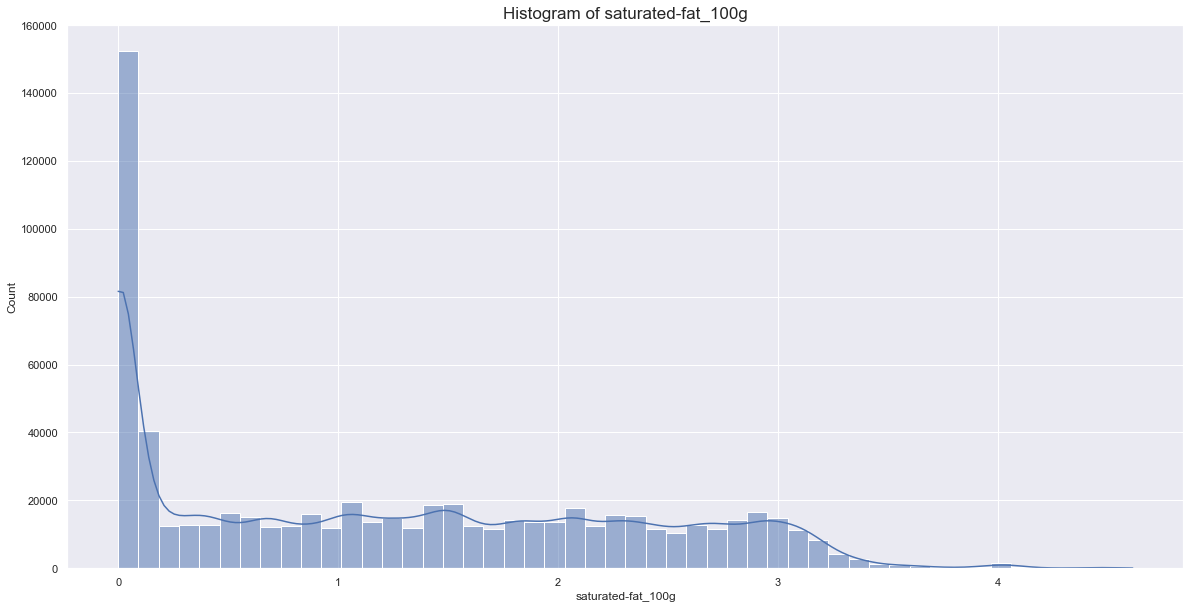

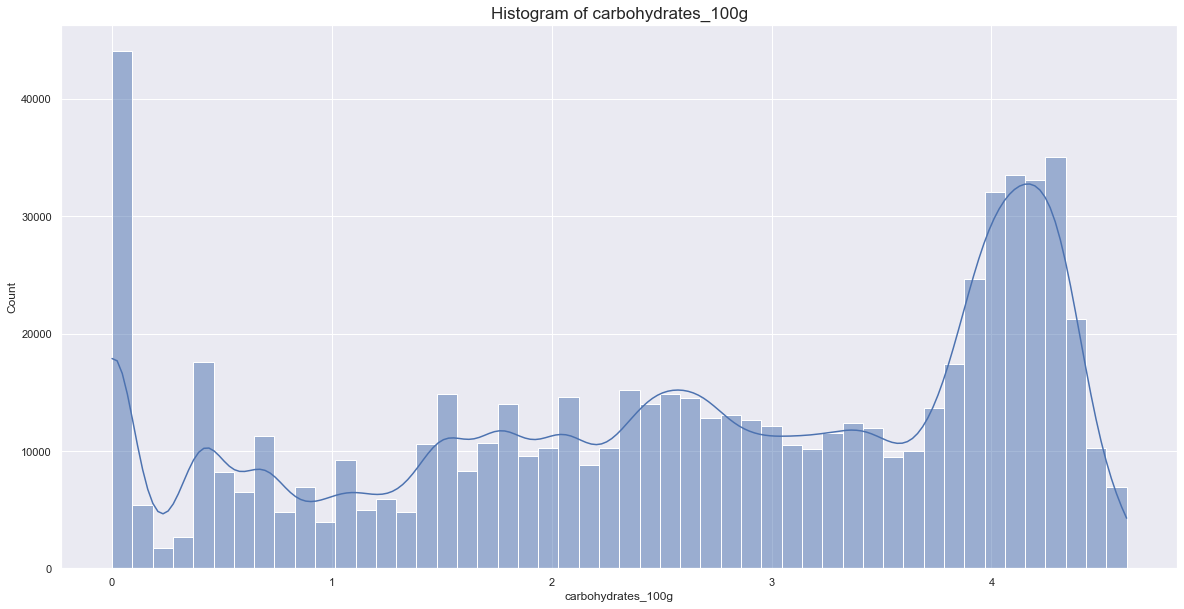

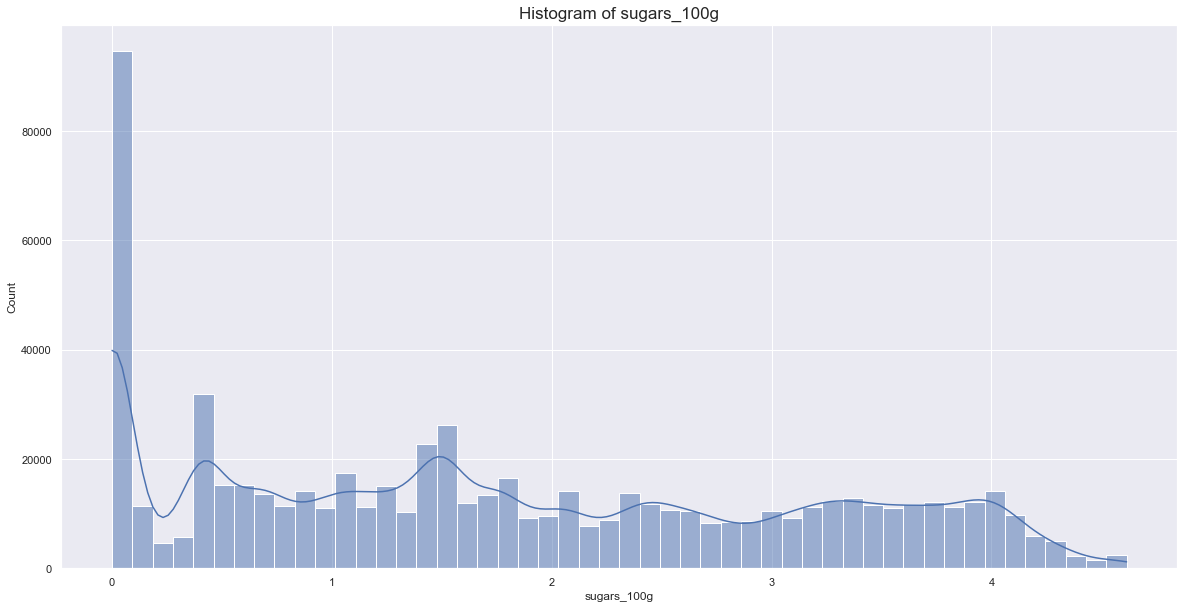

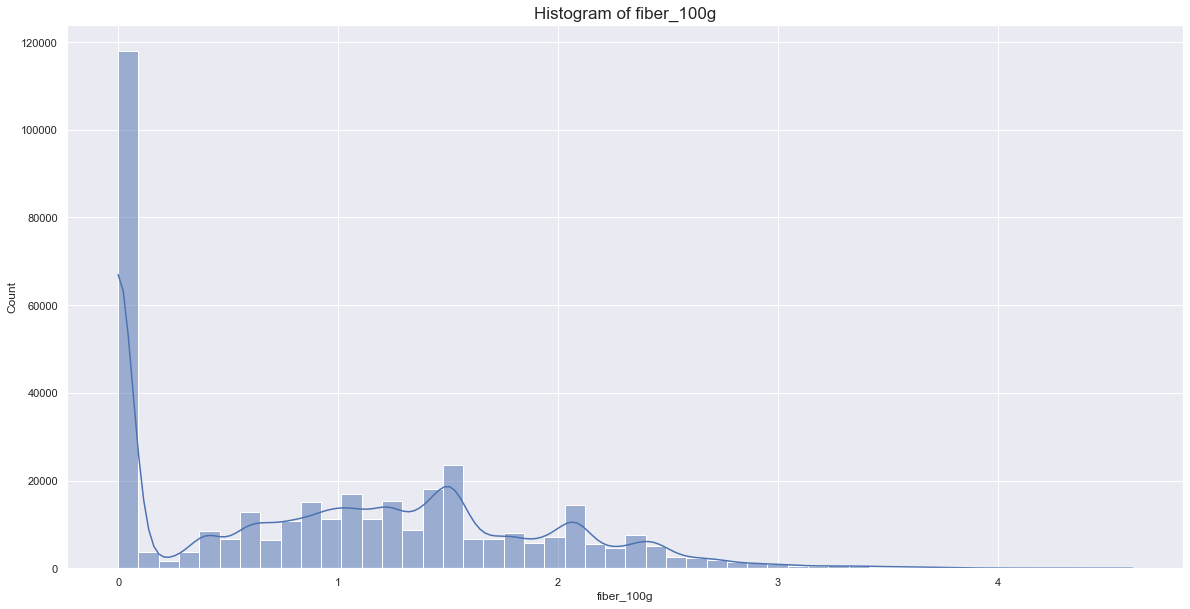

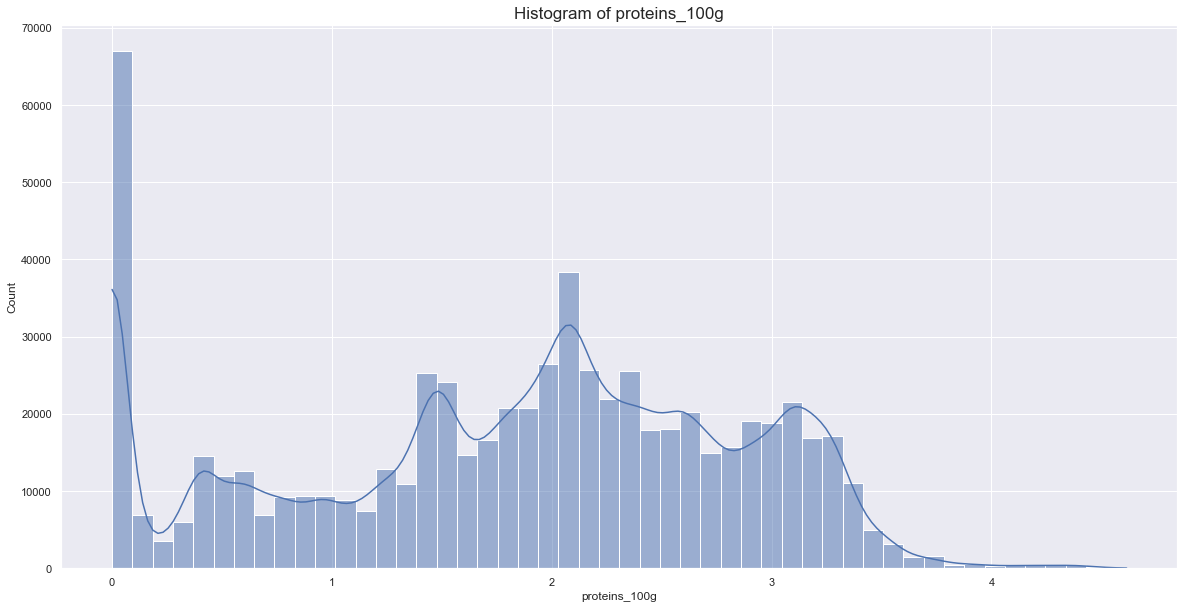

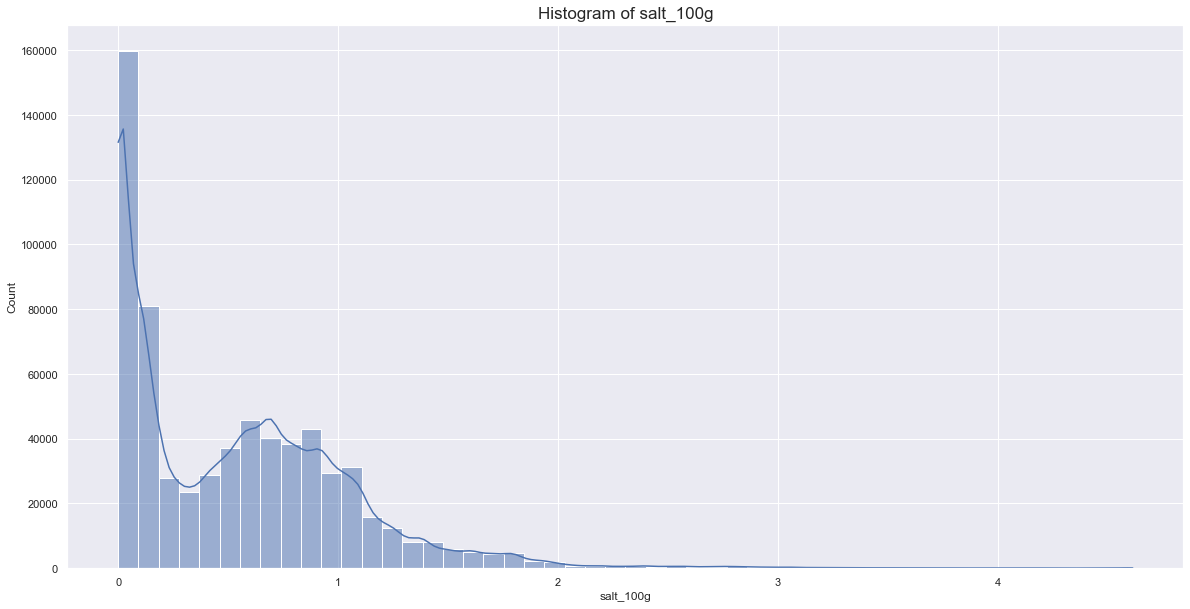

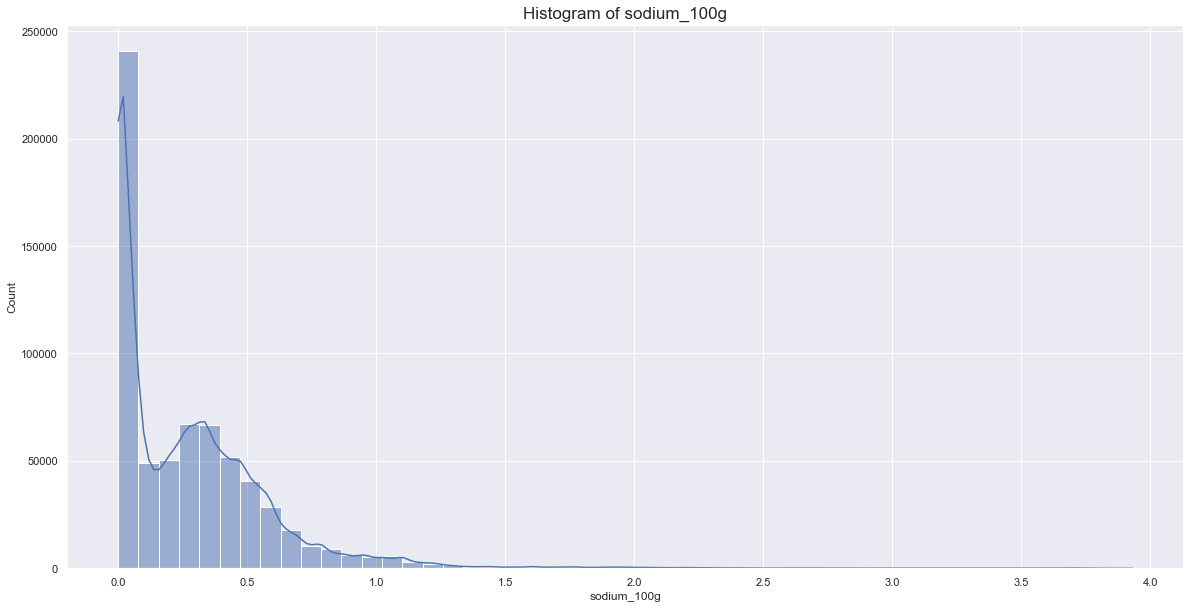

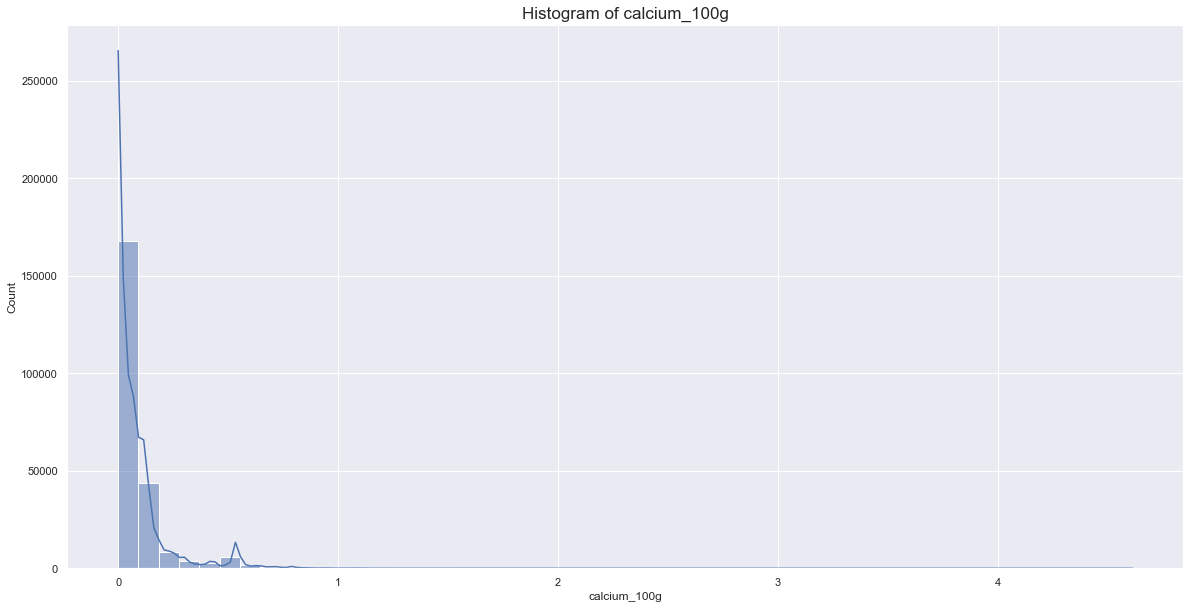

In [31]:
for col in df1log.select_dtypes('float'):
    plt.figure(figsize = (20,10))
    plt.title('Histogram of ' + col, size = 17)
    plt.xlabel(col, size = 12)
    sns.histplot(df1log[col], bins = 50, kde = True)

In [32]:
df1log = aberrantvalues(df1log, columns_to_treat)

In [33]:
df1log = aberrantvalues_2(df1log, columns_to_treat)

In [34]:
df1log = np.expm1(df1log)

In [35]:
df1[columns_to_treat] = df1log[columns_to_treat]

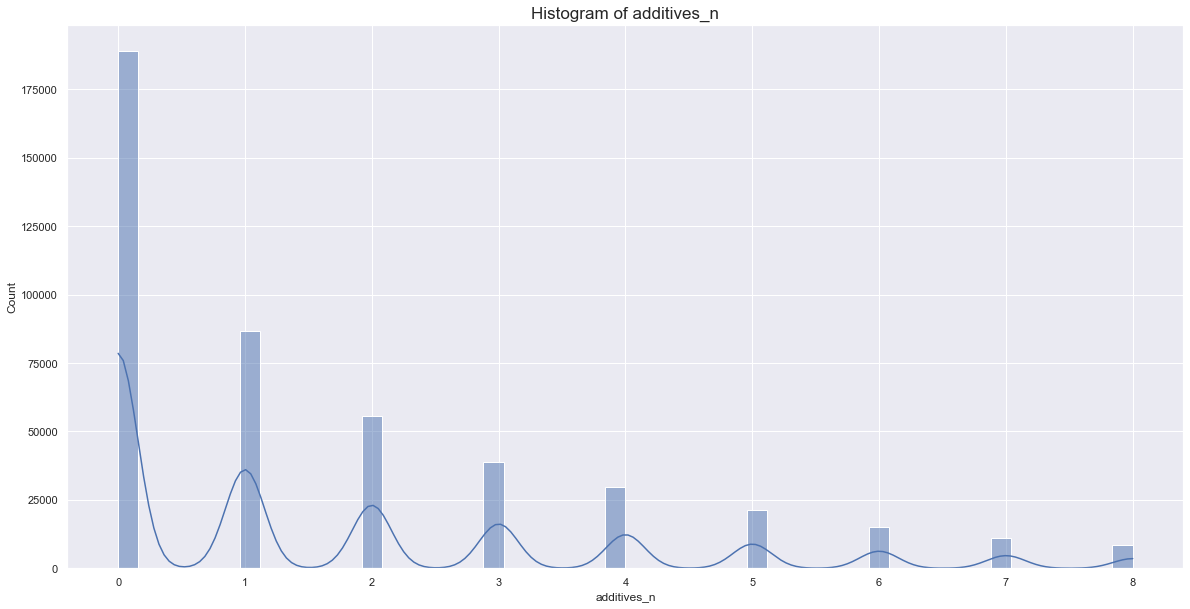

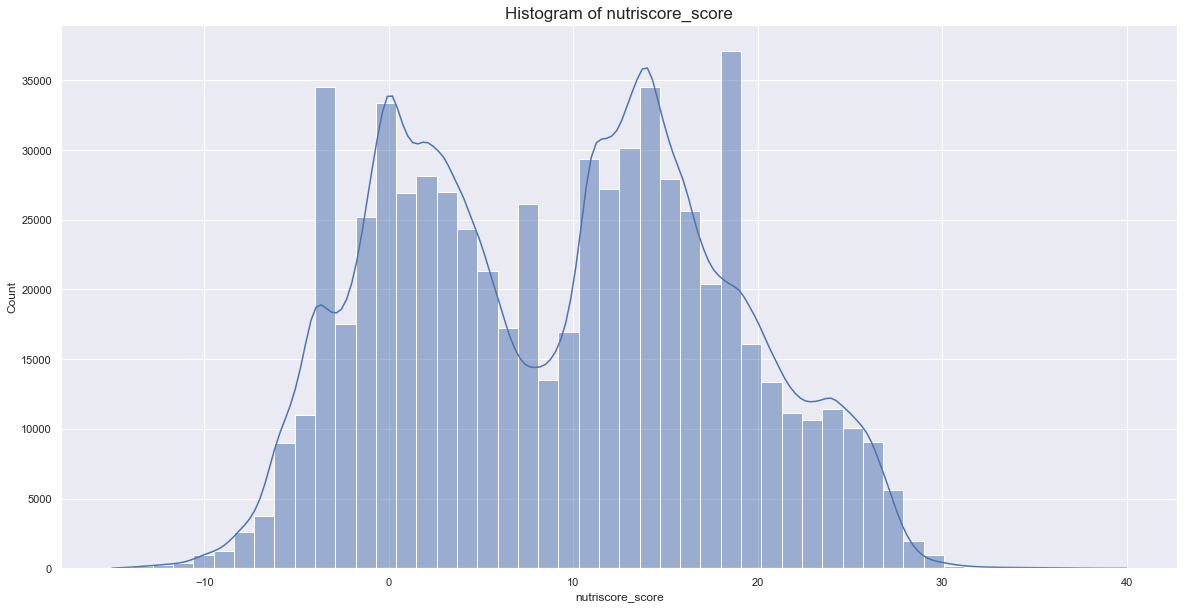

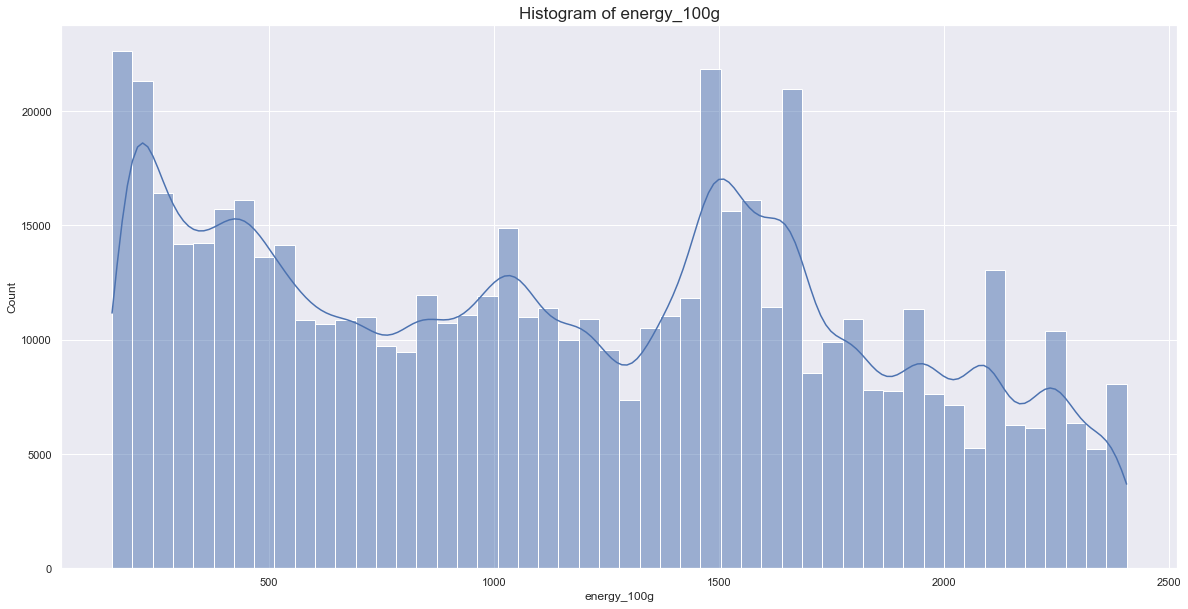

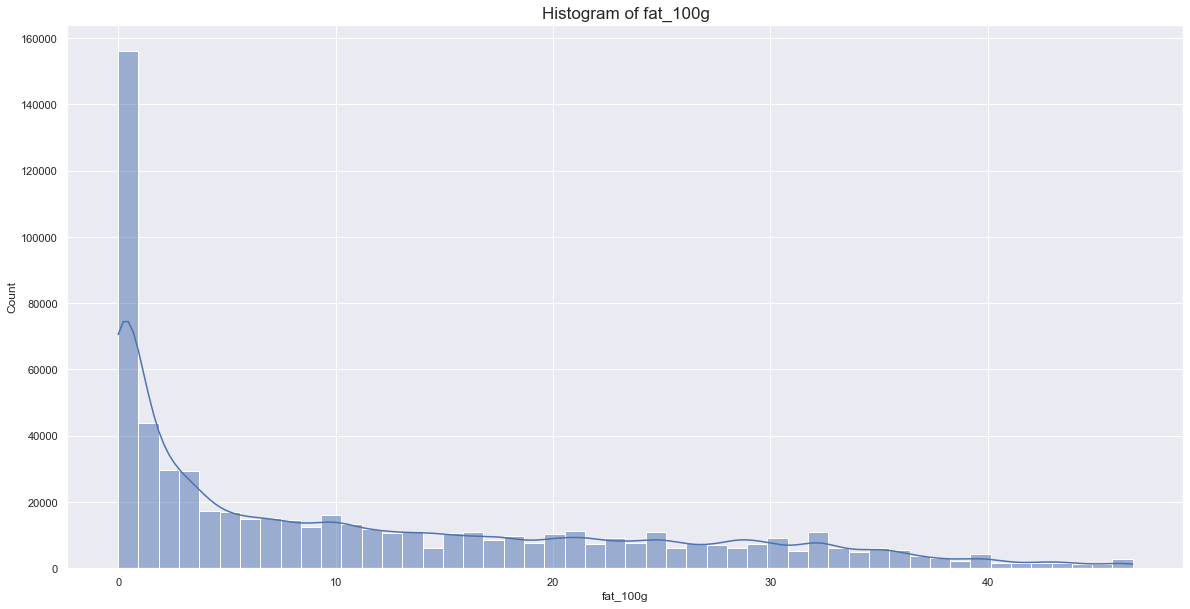

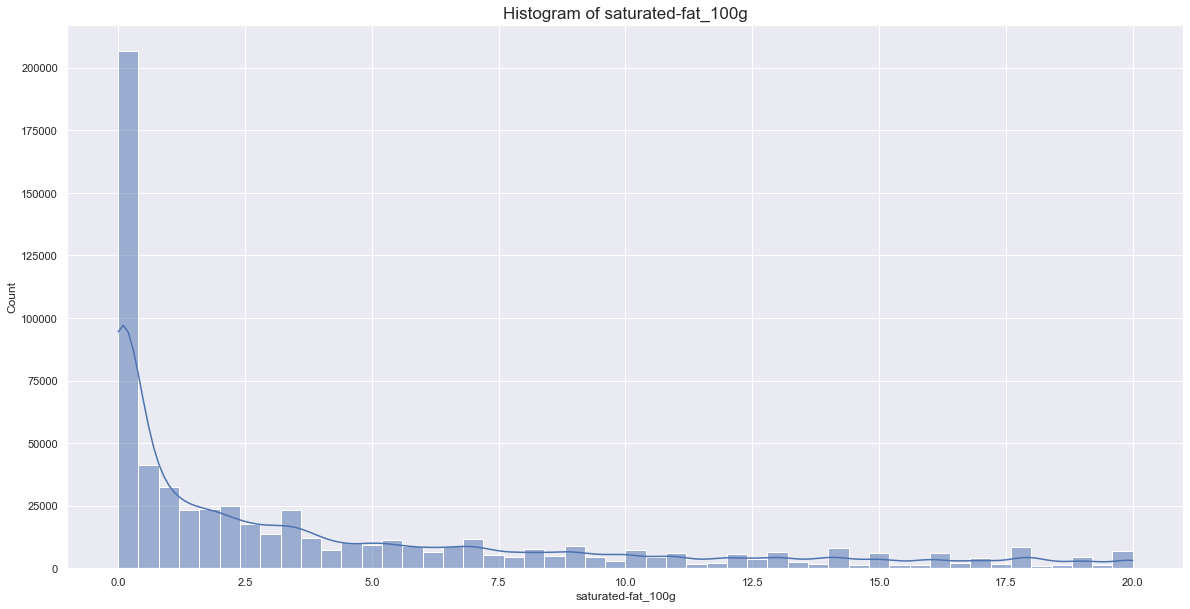

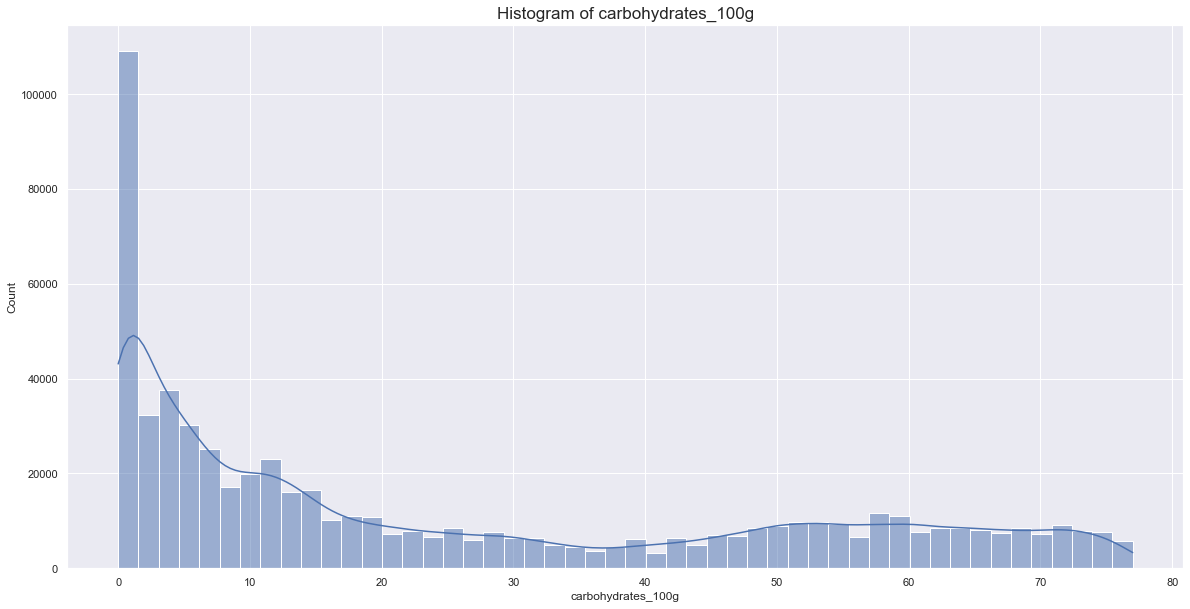

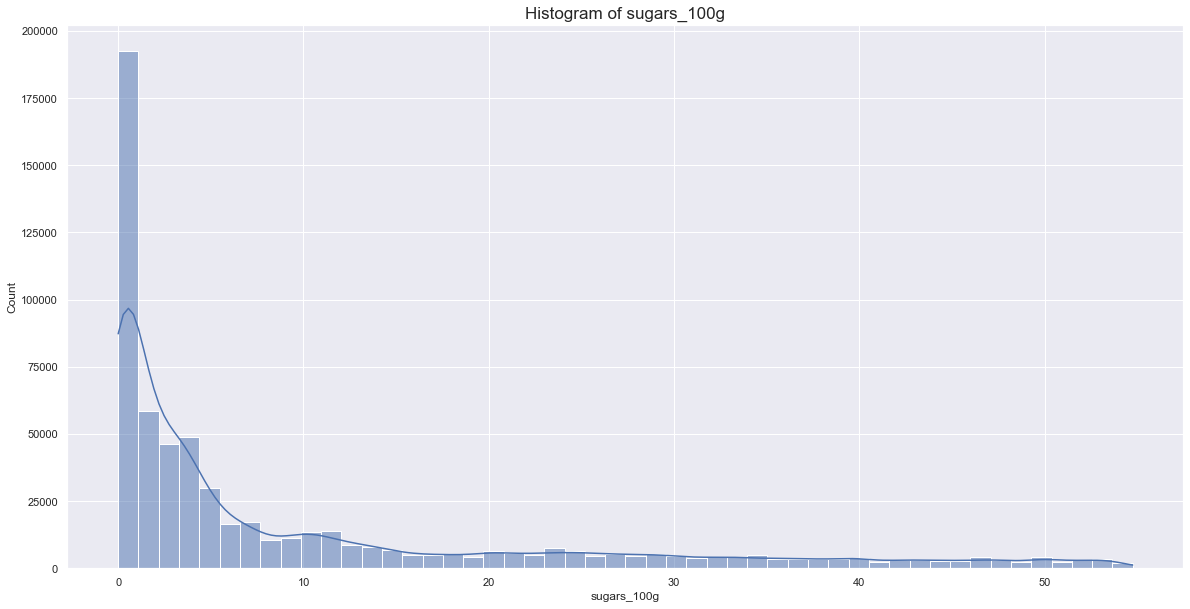

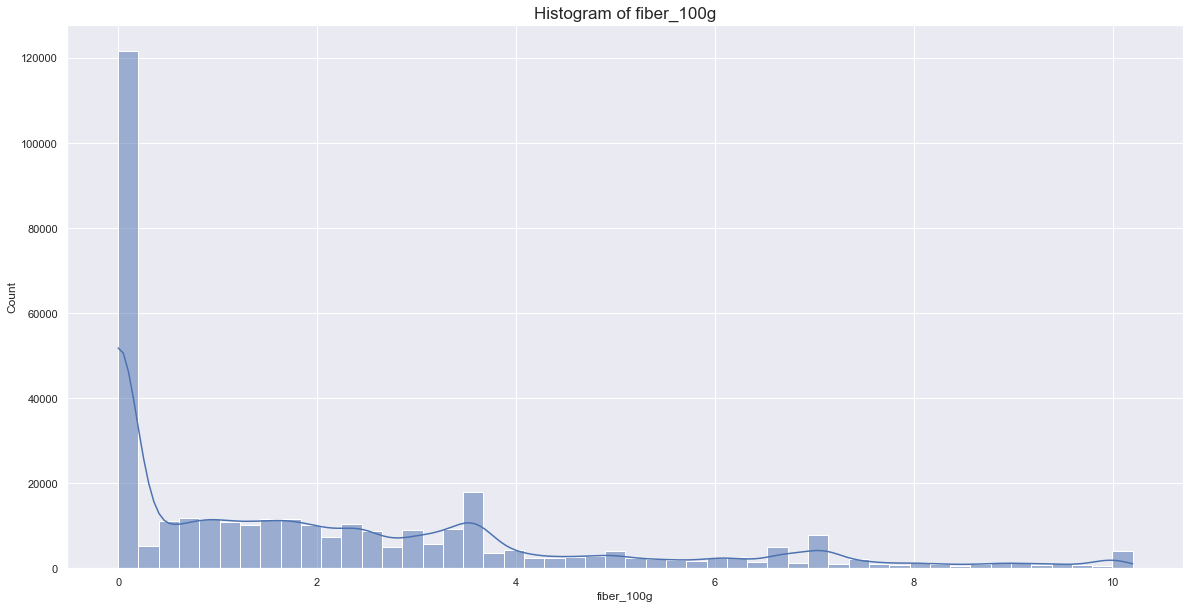

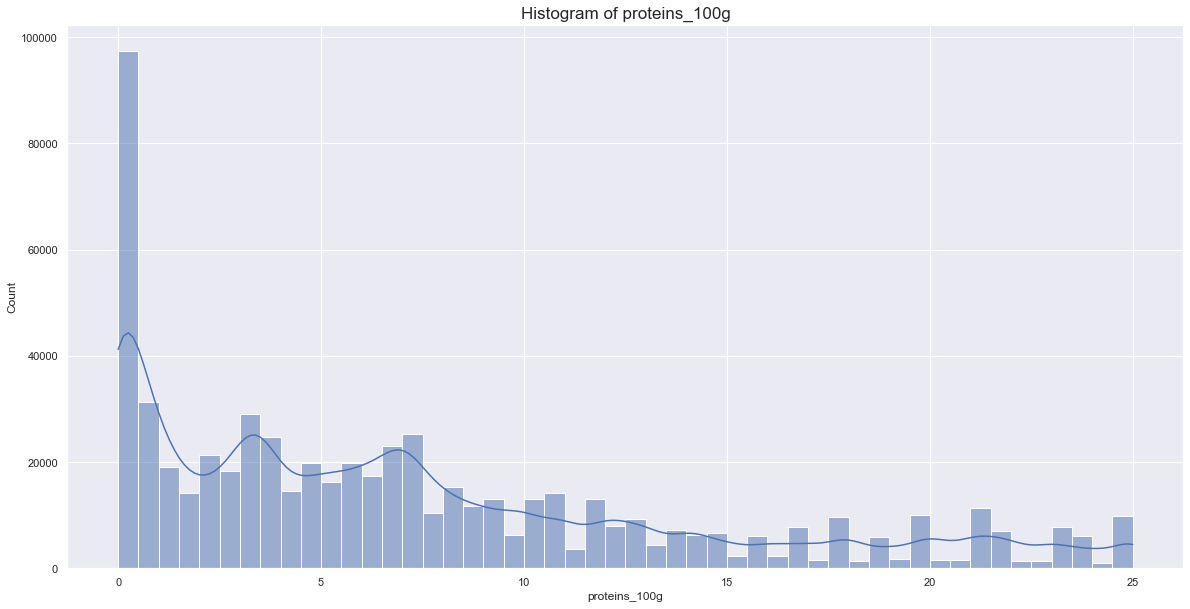

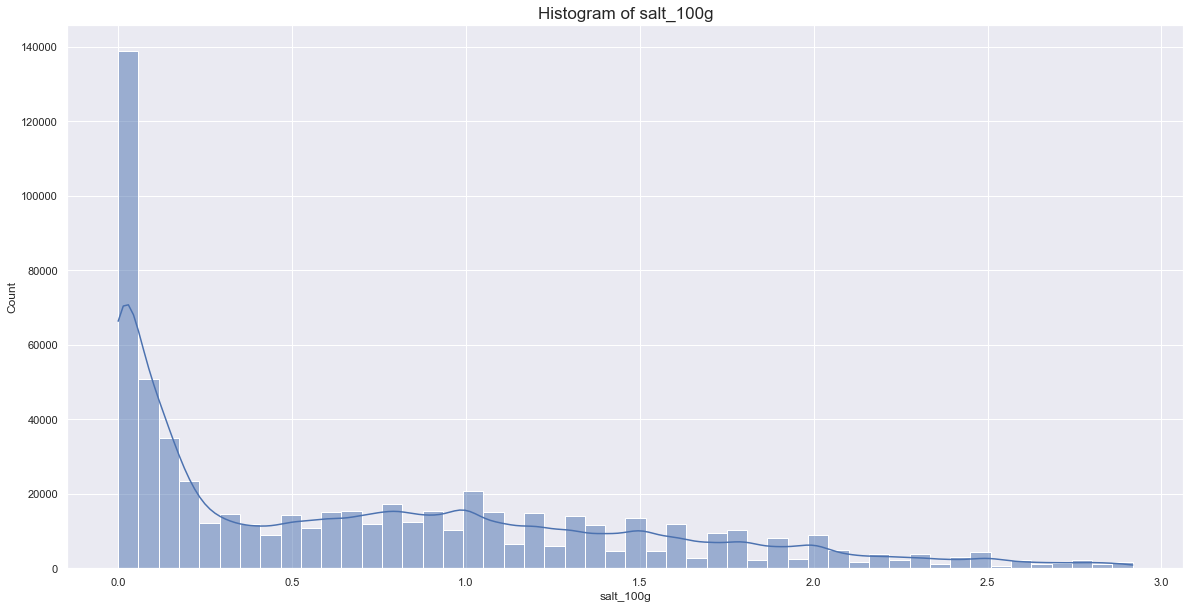

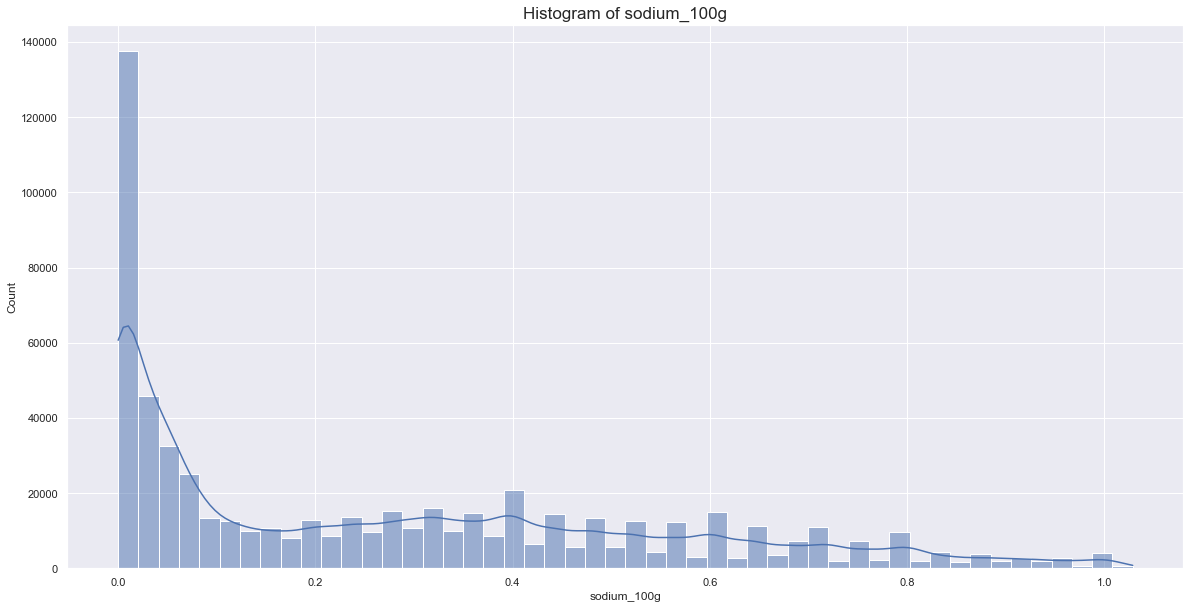

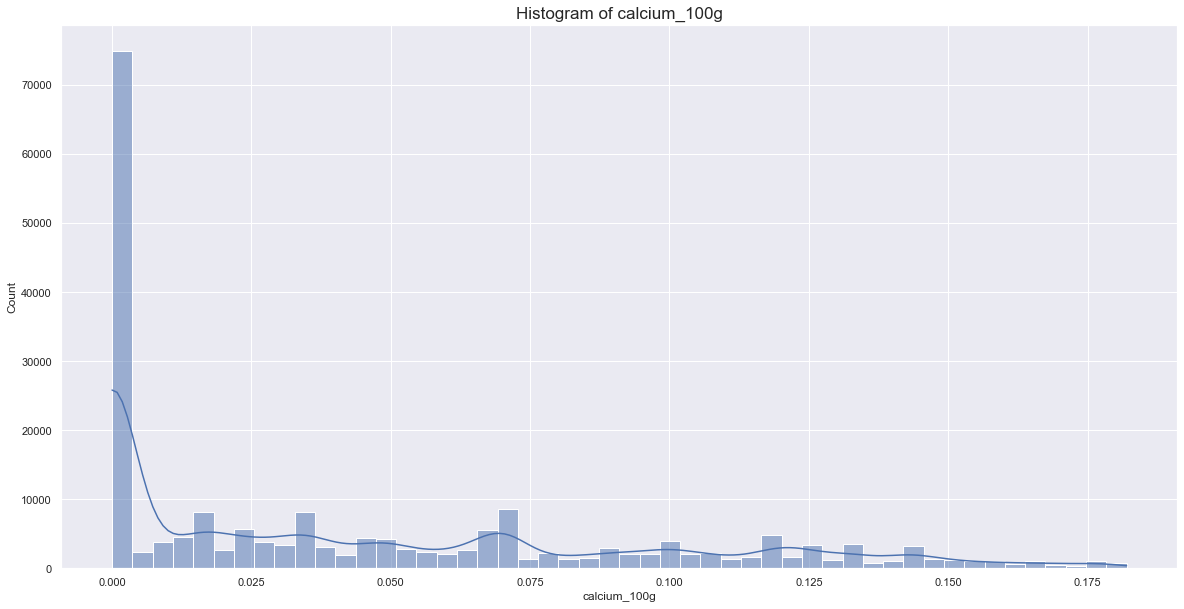

In [36]:
for col in df1.select_dtypes('float'):
    plt.figure(figsize = (20,10))
    plt.title('Histogram of ' + col, size = 17)
    plt.xlabel(col, size = 12)
    sns.histplot(df1[col], bins = 50, kde = True)

# 7. Filtering missing values

- Imputation by the mean of the group of "main_category_en" of the missing values for the float columns.
- Imputation by 0 the remaining missing values.
- The dataset finally has 664654 rows and 20 columns.
- The float columns are all filled.

In [37]:
df1 = ImputerMeanByGroup(df1, df1.select_dtypes('float'), 'main_category_en')

Dataset has  664654 rows and  20 columns
Number of non-null values by columns :
code                  664654
product_name          664654
brands                477226
categories_en         664652
countries_en          663806
ingredients_text      477291
additives_n           659603
nutriscore_score      664654
nutriscore_grade      664654
main_category_en      664652
energy_100g           660628
fat_100g              662958
saturated-fat_100g    663465
carbohydrates_100g    663266
sugars_100g           663480
fiber_100g            650904
proteins_100g         663676
salt_100g             663007
sodium_100g           662634
calcium_100g          522528
dtype: int64
Value type per column :
code                   object
product_name           object
brands                 object
categories_en          object
countries_en           object
ingredients_text       object
additives_n           float64
nutriscore_score      float64
nutriscore_grade       object
main_category_en       object
ene

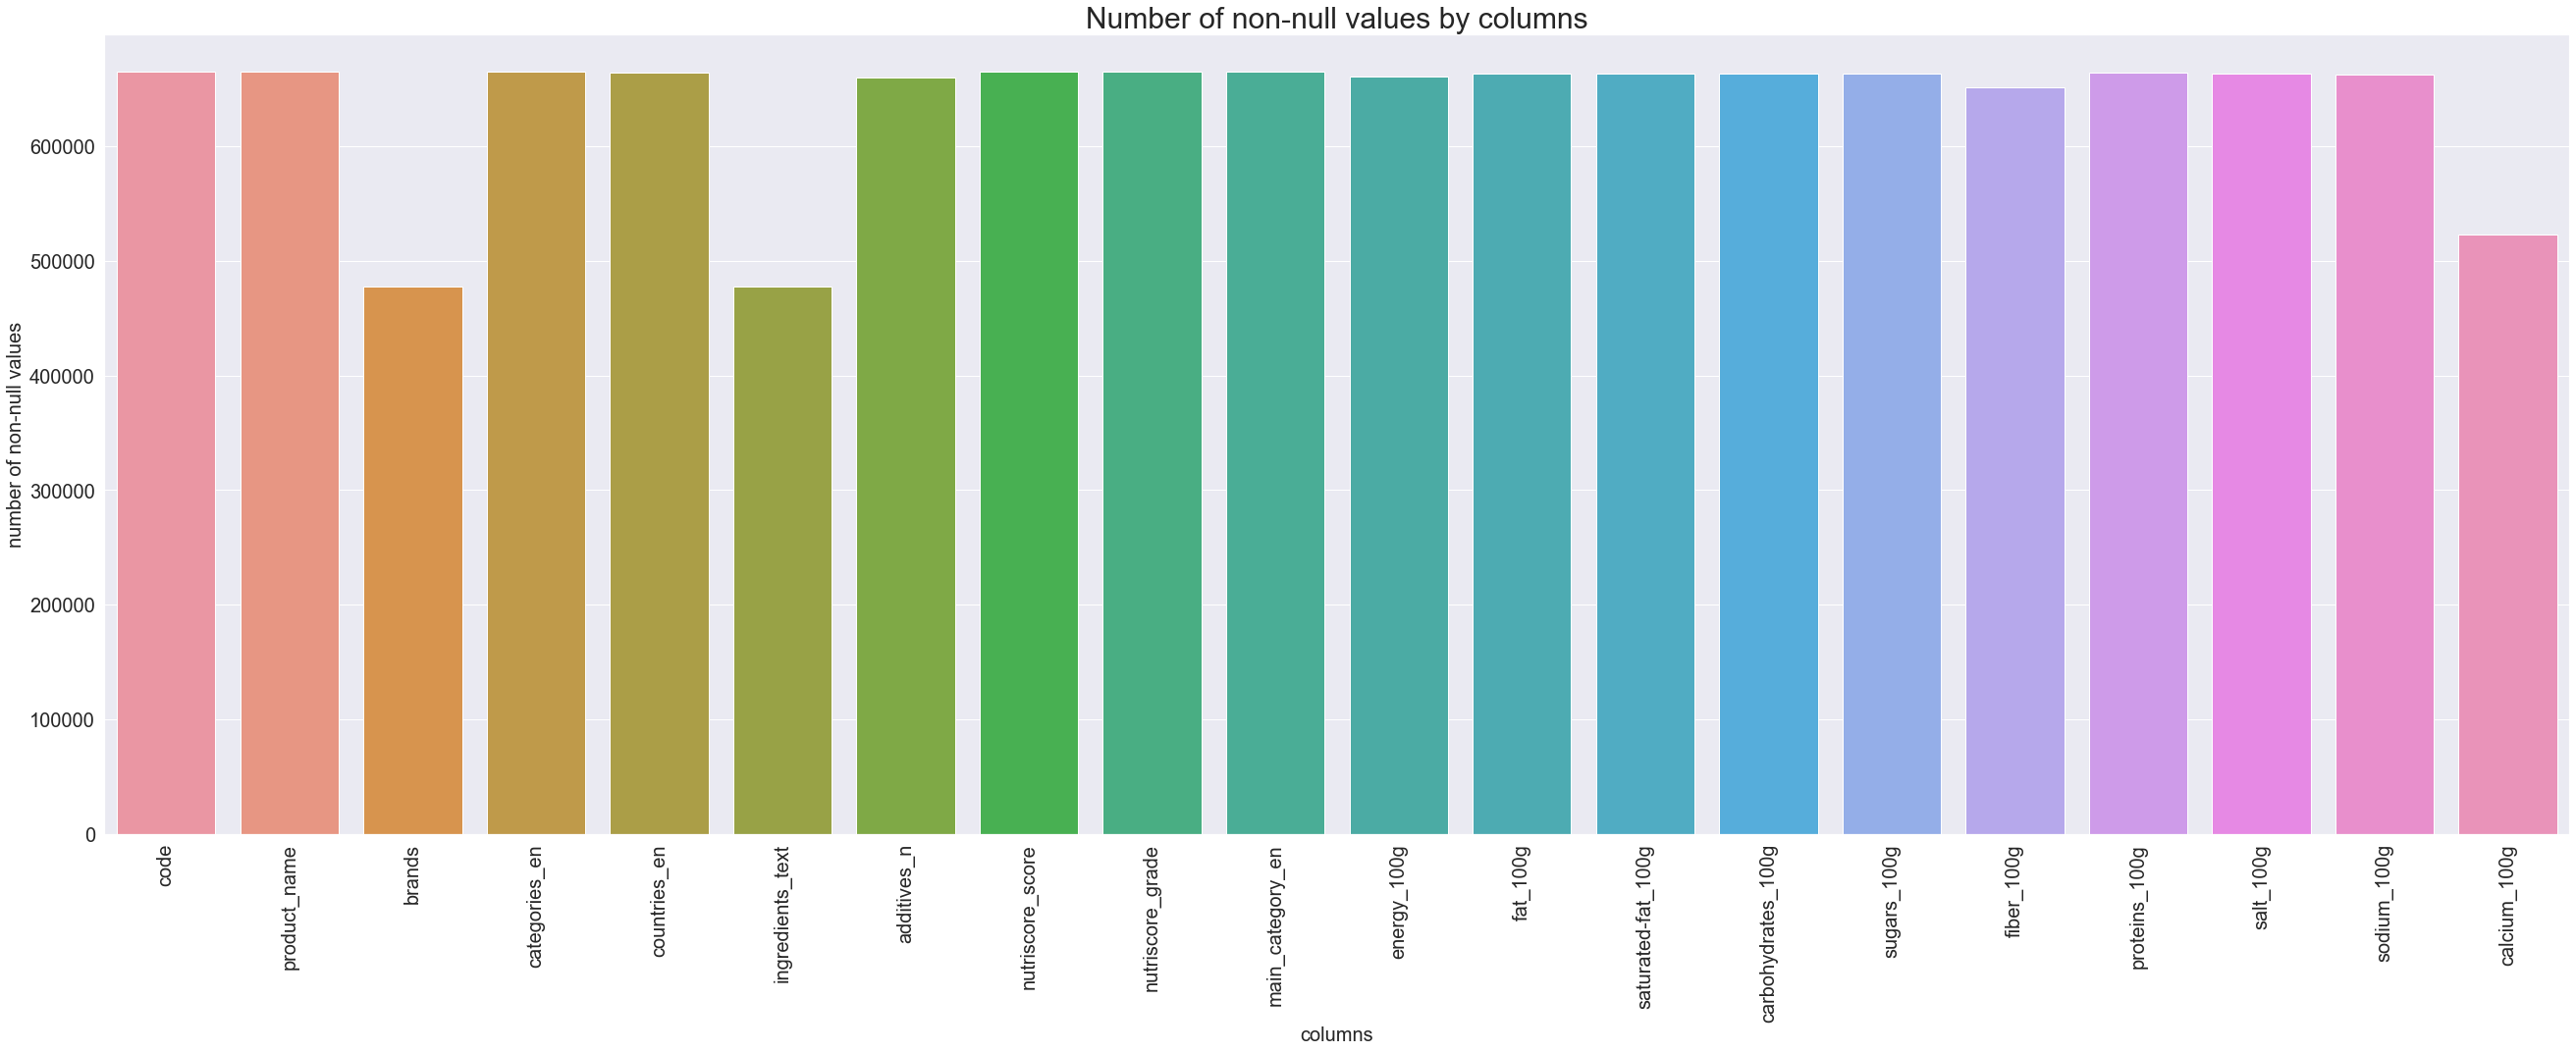

In [38]:
DataSetsExplo(df1)

In [39]:
columns_to_treat_NaN = df1.select_dtypes('float').columns

In [40]:
df1 = FilteringNaN_SimpleImp(df1, columns_to_treat_NaN, 'constant')

Dataset has  664654 rows and  20 columns
Number of non-null values by columns :
code                  664654
product_name          664654
brands                477226
categories_en         664652
countries_en          663806
ingredients_text      477291
additives_n           664654
nutriscore_score      664654
nutriscore_grade      664654
main_category_en      664652
energy_100g           664654
fat_100g              664654
saturated-fat_100g    664654
carbohydrates_100g    664654
sugars_100g           664654
fiber_100g            664654
proteins_100g         664654
salt_100g             664654
sodium_100g           664654
calcium_100g          664654
dtype: int64
Value type per column :
code                   object
product_name           object
brands                 object
categories_en          object
countries_en           object
ingredients_text       object
additives_n           float64
nutriscore_score      float64
nutriscore_grade       object
main_category_en       object
ene

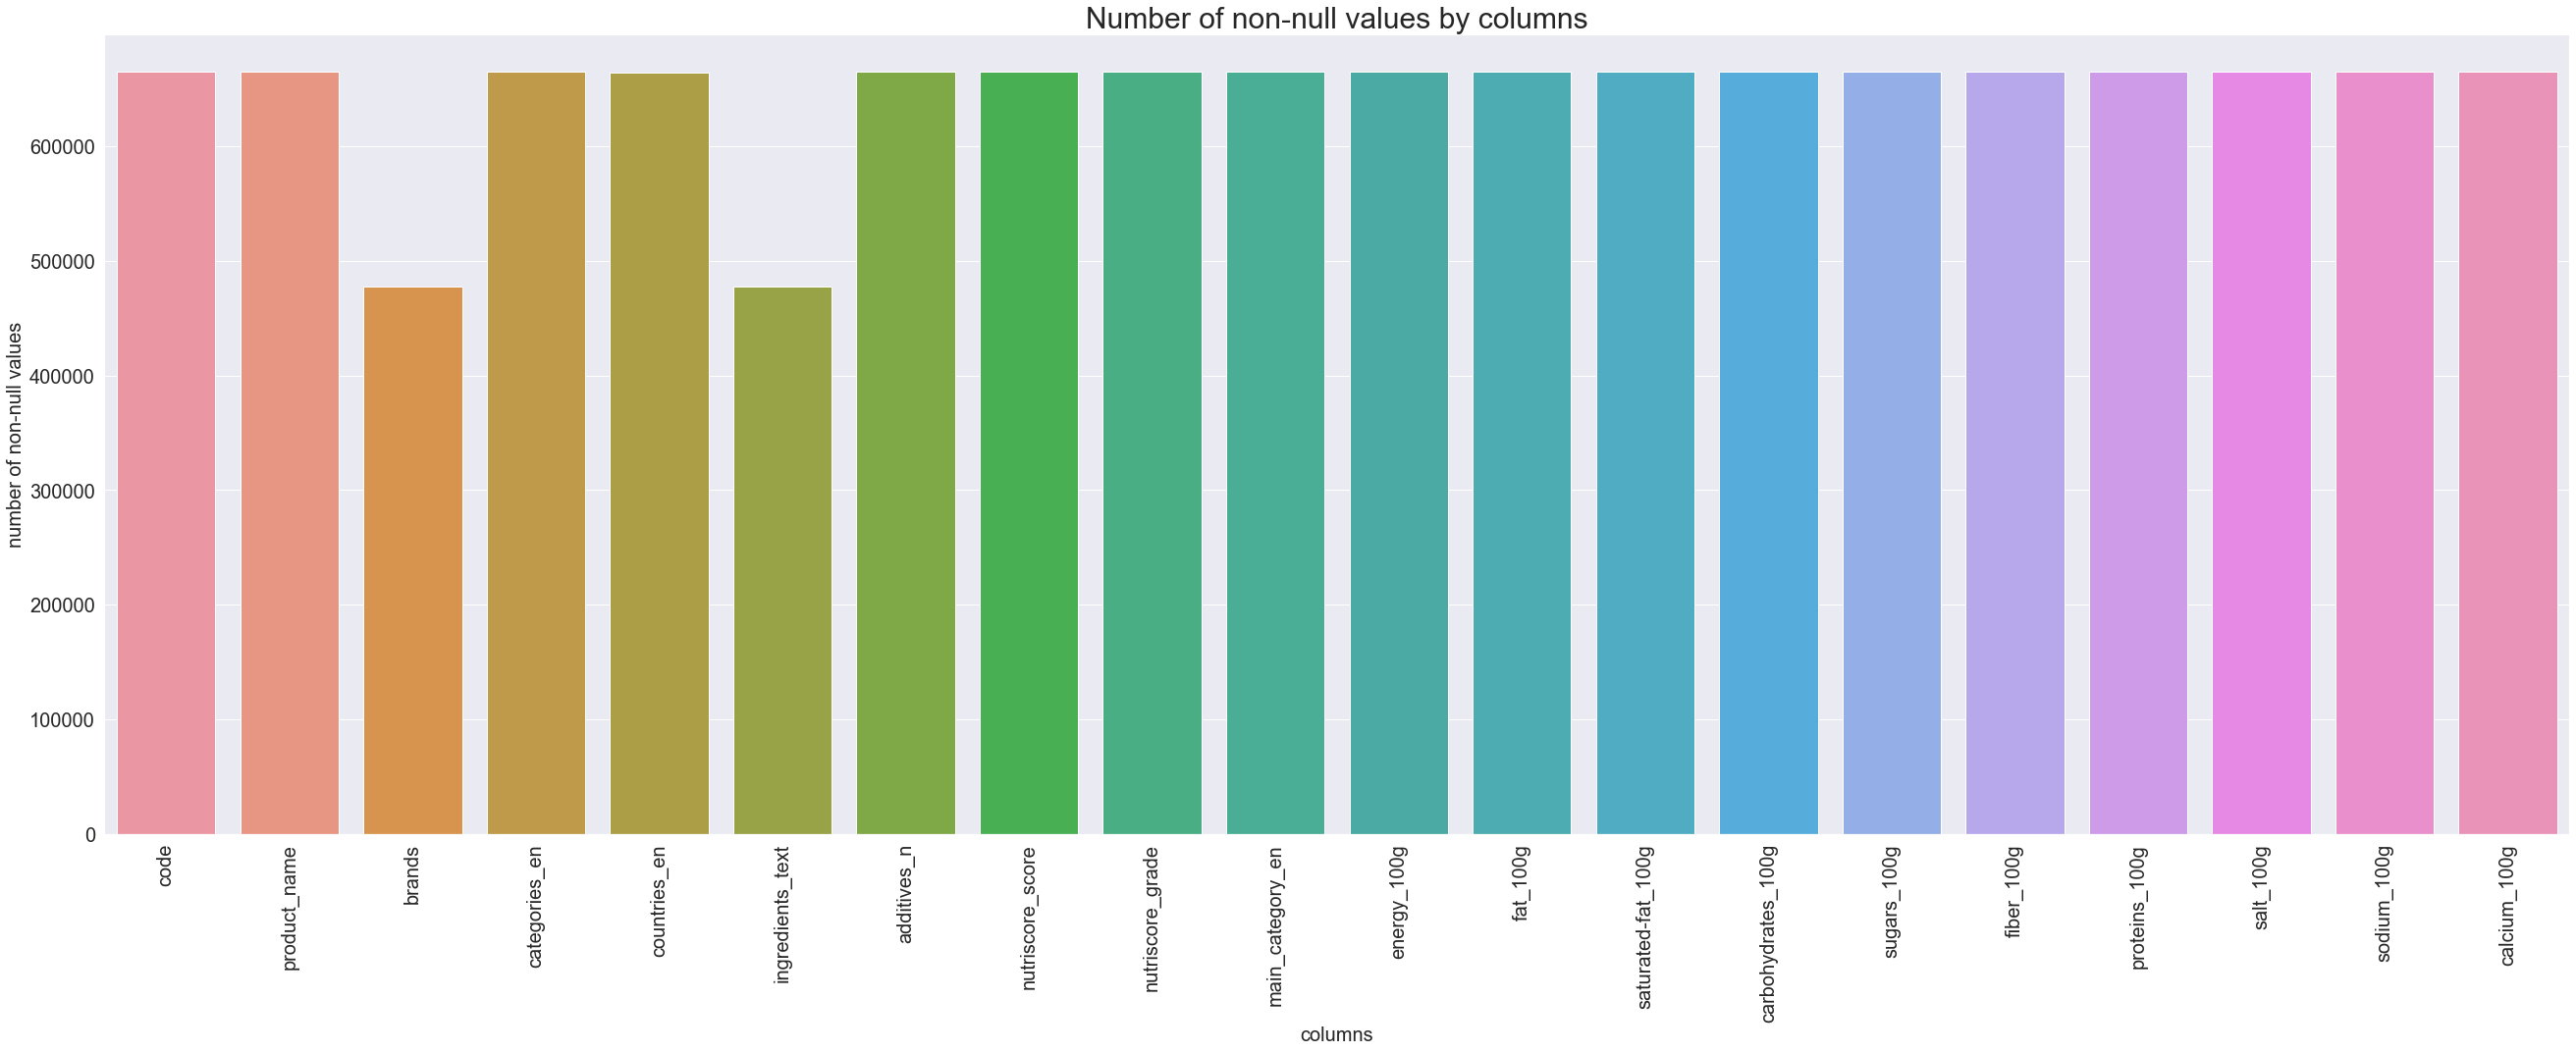

In [41]:
DataSetsExplo(df1)

In [42]:
df1.head()

,code,product_name,brands,categories_en,countries_en,ingredients_text,additives_n,nutriscore_score,nutriscore_grade,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g
4,0000000000100,moutarde au moût de raisin,courte paille,"Groceries,Condiments,Sauces,Mustards",France,eau graines de téguments de moutarde vinaigre ...,0.000000,18.0,d,Mustards,936.000,8.2,2.2,29.0,22.0,0.000000,5.1,1.873678,0.647679,0.00231
15,0000000000949,Salade de carottes râpées,NaN,"Meals,Prepared vegetables,Grated carrots,Seaso...",France,NaN,2.271523,1.0,b,Seasoned shredded carrots,379.424,0.3,0.1,5.3,3.9,2.667273,0.9,0.420000,0.168000,0.00000
24,0000000001281,Tarte noix de coco,"Crous Resto',Crous","Pies,Sweet pies,Coconut pies",France,NaN,3.000000,14.0,d,Coconut pies,1594.000,22.0,15.5,27.3,21.9,4.400000,4.6,0.100000,0.040000,0.01200
34,0000000001885,Compote de poire,Crous,"Plant-based foods and beverages,Plant-based fo...",France,NaN,0.888889,-2.0,a,Pear compotes,657.000,0.0,0.0,36.0,27.0,3.600000,0.6,0.000000,0.000000,0.00000
38,0000000002257,Salade de macedoine de légumes,NaN,"Meals,Prepared vegetables,Starters,Cold starte...",France,NaN,2.114286,1.0,b,Vegetables macedoines,598.000,12.7,1.0,3.9,1.0,3.076923,1.9,0.270000,0.108000,0.03000


In [43]:
df1.to_csv('P03_DataClean.csv')